# Instructions

This notebook contains the third project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access.
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: [add your link]

**Deadlines**

* Hand-in solution 7/12/25
* Peer grading 13/12/25


# Notebook pre steps

In [1]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection: Cmd+Shift+Enter

# install missing packages
# !pip install pymdptoolbox
!pip install dfply
import numpy as np
from pprint import pprint
import pandas as pd
from plotnine import *
import joblib
import gzip
import gdown
import warnings
from scipy.stats import norm
from dfply import *
import itertools
from IPython.display import Markdown
from typing import Any, Dict, List, Optional, Sequence, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from tqdm.auto import tqdm
import gymnasium as gym
from gymnasium import spaces

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 13.1 MB/s eta 0:00:00


# Problem description

Consider the [Hour-to-hour electricity market problem](https://colab.research.google.com/drive/1BFI6iRLTnrHgxgFayC89SKhuM3XcIp7s?usp=sharing) that we solved using a Markov decision process by discretising the state and action space.

Here, we are going to solve the problem using RL with approximation. How to solve the problem depends on which environment your are using. You may use one of the following environment for the problem:

1. The environment given in [Project 2](https://colab.research.google.com/drive/1HhQbV2ZvfMsEv-RkoGS6Sj0mjzC9QYF8?usp=sharing) which uses a discretization of both states and actions,
2. The environment given in the section "Environment with discrete actions" below.
3. The environment given in the section "Environment with continuous actions" below.

In all environments we represent state and actions using tuples $s_t = (s^l_t,s^c_t,s^w_t,s^p_t)$ and $a_t = (a^b_t, a^w_t, a^c_t)$. Moreover, we use settings:

In [2]:
settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}

# Environment with discrete actions

We here use an environment where

1. The battery only can be charged/discharged in units of $\delta$, e.g. $\delta = 1$ MWh. That is, $a^b_t \in \{-b^{\max}, \ldots, -\delta, 0, \delta, ..., b^{\max} \}$
2. Due to 1, the battery level is $s^l_t \in \{ 0, \delta, 2\delta, ..., b^{\max} \}$.
3. The same units are used for the wind energy production $a^w_t \in \{ 0, \delta, 2\delta, ..., p^{\max} \}$.
4. Due to 1-3, the commitment levels are $s^c_t \in \{ -b^\max, \ldots, -\delta, 0, \delta, \ldots, b^{\max} + p^{\max}\}$ since we can at most buy energy for an empty battery and we can at most sell max wind production plus a full battery. That is, $a^c_t$ have these commitment levels.

Note $\delta$ must satisfy that $b^{\max}/\delta$ and $p^{\max}/\delta$ are integer. Moreover, when calculating $E(x)$, its value must be rounded down so contained in the set defined for $a^w_t$.

To specify the discrete actions we only need to specify sets for the wind and commitment levels. Hence the battery levels will automatically be discrete too.

The environment is implemented below.


In [3]:
class EnvEnergyDiscrete:
    """
    Environment for the hour-to-hour electricity market problem with discrete actions.
    """

    def __init__(self, settings, a_w_tuple, a_c_tuple, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            a_w_tuple (list): A list of possible wind usage
            a_c_tuple (list): A list of possible commitment levels


            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

        self.a_c_tuple = a_c_tuple
        self.a_w_tuple = a_w_tuple

    def reset(self):
        s_l0 = 4.0      # initial battery level
        s_c0 = 0.0
        s_w0 = 14.0   # m/s, say
        s_p0 = 20.0  # €/MWh, say
        state = (float(s_l0), float(s_c0), float(s_w0), float(s_p0))
        return state


    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def get_left(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the largest number 'b' in
        the list so b <= a

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            float or int: The largest number 'b' in the list so b <= a.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)-1, -1, -1):
            if sorted_list[i] <= a:
                return sorted_list[i]
        return None

    def get_actions(self, s: tuple) -> list:
        """
        Get all possible actions for a given state.
        """
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.get_left(self.a_w_tuple, self.energy(s_w)) # max energy we can sell/produce (e.g. if energy(s_w) = 1.25 but a_w_tuple is [0,1,2,...] then can only sell 1)
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)

        actions = [(float(a_b), float(a_w), float(a_c)) for a_c in self.a_c_tuple if a_c >= -(b_max - (s_l - a_b))]
        # if -(b_max - (s_l - a_b)) > -10:
        #     print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        #     print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        #     print(min([a[2] for a in actions]))
        return actions

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def energy_inverse(self, energy_target, time_period_length = 1):
        """
        Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

        Args:
            energy_target (float): The target energy output in MWh.
            time_period_length (float, optional): The time period length in hours. Defaults to 1.

        Returns:
            float: The wind speed that produces the given energy.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']

        if energy_target < 0 or energy_target > p_max:
            return None

        def find_wind_speed(w):
            return self.energy(w, time_period_length) - energy_target

        sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
        return sol.root if sol.converged else None


    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return min(np.exp(log_wind_next_sample), 50)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = (s_l_next, s_c_next, s_w_next, s_p_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [4]:
def generate_discrete_set(min_val, max_val, step):
    """
    Generates a set of discrete values from min_val to max_val with step size.

    Args:
        min_val (float): The minimum value in the set.
        max_val (float): The maximum value in the set.
        step (float): The step size between consecutive values.

    Returns:
        set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
    """
    # Ensure step is a divisor of min_val
    if not np.isclose(min_val % step, 0):
        raise ValueError("min_val argument must be divisible by step.")
    if not np.isclose(max_val % step, 0):
        raise ValueError("max_val argument must be divisible by step.")
    return np.arange(min_val, max_val + step, step)

step_mwh = 2
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
a_w_tuple = generate_discrete_set(0, p_max, step_mwh)
a_c_tuple = generate_discrete_set(-b_max, c_max, step_mwh)

envD = EnvEnergyDiscrete(settings, a_w_tuple = a_w_tuple, a_c_tuple = a_c_tuple)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q1

Consider the code below and explain the output.

In [5]:
#@title Solution

import random

s = [4.0, 6.0, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    actions = envD.get_actions(s)  # a = (a_b, a_w, a_c)
    a = random.choice(actions)
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envD.get_step(s, a)
    s = [round(v,1) for v in s]
    a = [round(v,0) for v in a]
    print(f"{s}, Rew: {r:1.1f}")

display(Markdown("""
Here, we have discrete actions, which imply that the states $s_l$ and $s_c$ are also discrete.
We start with a state and pick a valid action randomly. Afterwards, the reward and
next state are sampled using the environment.
"""))

(s_l, s_c, s_w, s_p): [4.0, 6.0, 12.4, 34.7], (a_b, a_w, a_c): (-4.0, 10.0, 8.0) -> [8.0, 8.0, 28.0, 41.7], Rew: 208.2
(s_l, s_c, s_w, s_p): [8.0, 8.0, 28.0, 41.7], (a_b, a_w, a_c): (8.0, 0.0, -6.0) -> [0.0, -6.0, 32.4, 44.8], Rew: 333.6
(s_l, s_c, s_w, s_p): [0.0, -6.0, 32.4, 44.8], (a_b, a_w, a_c): (-6.0, 0.0, -2.0) -> [6.0, -2.0, 50.0, 47.9], Rew: -268.8
(s_l, s_c, s_w, s_p): [6.0, -2.0, 50.0, 47.9], (a_b, a_w, a_c): (-2.0, 0.0, 2.0) -> [8.0, 2.0, 50.0, 52.0], Rew: -95.8
(s_l, s_c, s_w, s_p): [8.0, 2.0, 50.0, 52.0], (a_b, a_w, a_c): (2.0, 0.0, 8.0) -> [6.0, 8.0, 8.4, 60.6], Rew: 104.0



Here, we have discrete actions, which imply that the states $s_l$ and $s_c$ are also discrete.
We start with a state and pick a valid action randomly. Afterwards, the reward and
next state are sampled using the environment.


# Environment with continuous actions

We here use an environment where both actions and states are continuous.

The environment is implemented below.


In [6]:
class EnvEnergyCont:
    """Energy storage environment with continuous actions.

    This class implements the physical / economic model for an
    hour-to-hour electricity market with wind and storage.

    State:
        s = (s_l, s_c, s_w, s_p)
            s_l: battery level [0, b_max]
            s_c: current contract (MWh)
            s_w: current wind speed (m/s)
            s_p: current price (EUR/MWh)

    Action:
        a = (a_b, a_w, a_c)
            a_b: battery power (charging if negative, discharging if positive)
            a_w: wind energy used (MWh)
            a_c: next-hour contract (MWh)
    """

    def __init__(self, settings: Dict[str, float], seed: int = 25_328) -> None:
        """Initializes environment, AR(1) models and RNG.

        Args:
            settings: Dictionary of environment parameters
                (b_max, c_max, p_max, w_cut_in, w_rated, w_cut_out,
                 c_plus, c_minus, ...).
            seed: Seed for the NumPy random number generator.
        """
        self.settings = settings

        # ------------------------------------------------------------------
        # Load AR(1) model for price from Google Drive.
        # ------------------------------------------------------------------
        price_url = (
            "https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR"
        )
        price_filename = "prices_ar1.pkl.gz"
        gdown.download(price_url, price_filename, quiet=True)

        with gzip.open(price_filename, "rb") as file:
            self.model_price = joblib.load(file)

        # ------------------------------------------------------------------
        # Load AR(1) model for log-wind from Google Drive.
        # ------------------------------------------------------------------
        wind_url = (
            "https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB"
        )
        wind_filename = "wind_log_ar1.pkl.gz"
        gdown.download(wind_url, wind_filename, quiet=True)

        with gzip.open(wind_filename, "rb") as file:
            self.model_wind = joblib.load(file)

        # NumPy RNG for all stochastic components.
        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed: int) -> None:
        """Resets the RNG with a new seed.

        Args:
            seed: New RNG seed.
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, state: Tuple[float, float, float, float]) -> None:
        """Checks that a state is within the allowed bounds.

        Args:
            state: Tuple (s_l, s_c, s_w, s_p).

        Raises:
            AssertionError: If any component is outside allowed bounds.
        """
        s_l, s_c, s_w, _ = state
        b_max = self.settings["b_max"]

        assert 0 <= s_l <= b_max
        assert -b_max <= s_c <= self.settings["c_max"]
        assert s_w >= 0

    def check_a(self, action: Tuple[float, float, float]) -> None:
        """Checks that an action is within the allowed bounds.

        Args:
            action: Tuple (a_b, a_w, a_c).

        Raises:
            AssertionError: If any component is outside allowed bounds.
        """
        a_b, a_w, a_c = action
        b_max = self.settings["b_max"]

        assert -b_max <= a_b <= b_max
        assert a_w >= 0
        assert -b_max <= a_c <= self.settings["c_max"]

    def get_action_info(self, state: Tuple[float, float, float, float]) -> tuple:
        """Computes physically feasible (a_b, a_w) and minimal a_c.

        Given current state, this enforces that:
          * Battery does not over- or underflow.
          * Wind production is not exceeded.
          * a_c_min avoids buying more than can be stored.

        Args:
            state: Tuple (s_l, s_c, s_w, s_p).

        Returns:
            Tuple (a_b, a_w, a_c_min).
        """
        self.check_s(state)
        s_l, s_c, s_w, _ = state
        b_max = self.settings["b_max"]
        e_max = self.energy(s_w)  # maximum wind energy available

        # Case 1: current contract nonnegative (selling or zero).
        if s_c >= 0:
            if s_c >= e_max:
                # Contract exceeds wind; we may need battery discharge.
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else:
                # Wind can almost cover contract; possibly charge battery.
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else:
            # Case 2: current contract negative (buying).
            # Try to charge battery while respecting max capacity.
            a_b = -min(b_max - s_l, -s_c + e_max)
            a_w = max(0, -a_b + s_c)

        # Minimal feasible a_c such that we do not overfill the battery.
        a_c_min = -(b_max - (s_l - a_b))

        return float(a_b), float(a_w), float(a_c_min)

    def power(self, wind_speed: float) -> float:
        """Computes turbine power output given wind speed.

        Args:
            wind_speed: Wind speed in m/s.

        Returns:
            Power output in MW.
        """
        p_max = self.settings["p_max"]
        w_cut_in = self.settings["w_cut_in"]
        w_rated = self.settings["w_rated"]
        w_cut_out = self.settings["w_cut_out"]

        if wind_speed < w_cut_in:
            return 0.0
        if w_cut_in <= wind_speed <= w_rated:
            # Cubic ramp from cut-in to rated.
            ratio = (wind_speed - w_cut_in) / (w_rated - w_cut_in)
            return p_max * ratio**3
        if w_rated < wind_speed <= w_cut_out:
            return p_max

        return 0.0

    def energy(self, wind_speed: float, time_period_length: float = 1.0) -> float:
        """Computes energy output over a time period.

        Args:
            wind_speed: Wind speed in m/s.
            time_period_length: Duration in hours (default = 1).

        Returns:
            Energy in MWh.
        """
        return self.power(wind_speed) * time_period_length

    def get_reward(
        self,
        price: float,
        contract: float,
        a_b: float,
        a_w: float,
    ) -> float:
        """Computes reward (profit minus imbalance penalty).

        Args:
            price: Current price s_p (EUR/MWh).
            contract: Current contract s_c (MWh).
            a_b: Battery power (MWh).
            a_w: Wind energy used (MWh).

        Returns:
            Reward (EUR) for current hour.
        """
        c_plus = self.settings["c_plus"]
        c_minus = self.settings["c_minus"]
        e = a_b + a_w  # actual delivered energy

        if price >= 0:
            # Penalty for deviations with penalty rate c_plus.
            return contract * price - c_plus * abs(contract - e)

        # Negative prices; different penalty c_minus.
        return contract * price - c_minus * abs(contract - e)

    def generate_price_next_hour(self, price: float) -> float:
        """Samples next-hour price from AR(1) model.

        Args:
            price: Current price.

        Returns:
            Sampled next-hour price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()

        # AR(1) mean.
        mean_next_price = intercept + phi * price

        return float(self.rng.normal(loc=mean_next_price, scale=sigma))

    def generate_wind_next_hour(self, wind_speed: float) -> float:
        """Samples next-hour wind speed from log-AR(1) model.

        Args:
            wind_speed: Current wind speed.

        Returns:
            Sampled next-hour wind speed.
        """
        min_pos = 1e-6  # avoid log(0)
        log_wind = np.log(max(wind_speed, min_pos))

        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()

        # AR(1) on log-wind.
        mean_log_next = intercept + phi * log_wind
        log_next = self.rng.normal(loc=mean_log_next, scale=sigma)

        return float(np.exp(log_next))

    def get_step(
        self,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
    ) -> Tuple[List[float], float]:
        """Applies transition dynamics for one step.

        Args:
            state: Current state (s_l, s_c, s_w, s_p).
            action: Action (a_b, a_w, a_c).

        Returns:
            Tuple (next_state, reward).
        """
        self.check_s(state)
        self.check_a(action)

        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        # Battery level after charging/discharging.
        s_l_next = float(s_l - a_b)
        # Next-hour contract is chosen a_c.
        s_c_next = float(a_c)
        # Wind and price evolve according to AR(1) models.
        s_w_next = float(self.generate_wind_next_hour(s_w))
        s_p_next = float(self.generate_price_next_hour(s_p))

        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)

        reward = float(self.get_reward(s_p, s_c, a_b, a_w))

        return s_next, reward


Let us create an instance of the class:

In [7]:
envC = EnvEnergyCont(settings)

## Q2

Consider the code below and explain the output.

In [8]:
#@title Solution

import random

s = [4.6, 12.7, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    a_b, a_w, a_c_min = envC.get_action_info(s)  # a = (a_b, a_w, a_c)
    a_c = random.uniform(a_c_min, c_max)
    a = (a_b, a_w, a_c)
    a = [round(v,1) for v in a]
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envC.get_step(s, a)
    s = [round(v,1) for v in s]
    print(f"{s}, Rew: {r:1.1f}")

display(Markdown("""
Here, we have continuous actions and states.
We start with a state and pick a valid action uniformly. Afterwards, the reward and
next state are sampled using the environment.
"""))

(s_l, s_c, s_w, s_p): [4.6, 12.7, 12.4, 34.7], (a_b, a_w, a_c): [2.7, 10.0, -4.4] -> [1.9, -4.4, 28.0, 41.7], Rew: 440.7
(s_l, s_c, s_w, s_p): [1.9, -4.4, 28.0, 41.7], (a_b, a_w, a_c): [-4.4, 0.0, 7.9] -> [6.3, 7.9, 32.4, 44.8], Rew: -183.5
(s_l, s_c, s_w, s_p): [6.3, 7.9, 32.4, 44.8], (a_b, a_w, a_c): [6.3, 0.0, -3.9] -> [0.0, -3.9, 52.6, 47.9], Rew: 273.9
(s_l, s_c, s_w, s_p): [0.0, -3.9, 52.6, 47.9], (a_b, a_w, a_c): [-3.9, 0.0, -5.0] -> [3.9, -5.0, 116.1, 52.0], Rew: -186.8
(s_l, s_c, s_w, s_p): [3.9, -5.0, 116.1, 52.0], (a_b, a_w, a_c): [-5.0, 0.0, 15.6] -> [8.9, 15.6, 11.8, 60.6], Rew: -260.0



Here, we have continuous actions and states.
We start with a state and pick a valid action uniformly. Afterwards, the reward and
next state are sampled using the environment.


# Q3 - Solving the problem

Our objective is to maximise the average reward. Pick one of the environments above and solve the problem. Note in theory by having continuous actions, you don't limit you action space and you should be able to get a better objective value.

For solving the problem, you have different options:

1. Implement classes for state-value and policy approximation and apply an actor-critic algorithm, similar to what we have done in the course.
2. Convert the environment into a Gym-style RL environment so it can be used with an RL library. Then, utilise the RL library to solve the problem. Note that in most RL libraries, the objective is discounted reward, which we have argued is not the most suitable choice for continuing problems. However, if you use a discount rate close to 1 (such as 0.9999), you can mimic the average reward objective.

State and clearly connect your choices to (also holds if you use Deep RL):

* The average reward objective.
* Theory regarding state-value approximations.
* Theory about policy approximations.
* Theory used which has not been presented in the course.

ChatGPT (or similar) can be useful for initial guidance, but remember to critically evaluate and understand the reasoning behind your choices. If you require GPU acceleration in Colab, then change the runtime type to GPU-T4 (the dropdown beside RAM in the upper right corner).




## Solution using discrete actions

We apply an actor-critic algorithm using nural networks for the policy and value approximations. We use PyTorch for representing the neural networks.

* `ValueFunctionNN`: Neural network with 2 hidden layers for calculating the baseline $v(s)$. That is, we approximate $v(s)$ using a NN instead of linear features.
* `SoftmaxActorAC`: Neural network with 2 hidden layers for calculating the softmax policy over discrete a_c values, constrained by `env.get_actions(s)`.



In [9]:
#@title Policy and state-value approximations (NN)

# =============================================================================
# Helper: device detection (works on Colab with T4 GPU)
# =============================================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# NN/MLP builder
# =============================================================================

def build_mlp(
    input_dim: int,
    output_dim: int,
    hidden_sizes: Sequence[int] = (64, 64),
    activation: nn.Module = nn.Tanh,
) -> nn.Module:
    """Builds a simple fully connected neural network / Multilayer
    Perceptron (MLP) network.

    Args:
        input_dim: Input feature dimension.
        output_dim: Output dimension.
        hidden_sizes: Sizes of hidden layers.
        activation: Activation class (not instance), e.g. nn.ReLU.

    Returns:
        An nn.Sequential model.
    """
    layers: List[nn.Module] = []
    prev_dim = input_dim

    # Hidden layers: Linear -> activation for each hidden size.
    for hidden_size in hidden_sizes:
        layers.append(nn.Linear(prev_dim, hidden_size))
        layers.append(activation())
        prev_dim = hidden_size

    # Final linear layer (no activation): outputs scalar or logits.
    layers.append(nn.Linear(prev_dim, output_dim))

    return nn.Sequential(*layers)


# =============================================================================
# Value function v(s; w) – critic
# =============================================================================

class ValueFunctionNN:
    """Neural value function v(s) for continuing tasks.

    This critic is compatible with actor_critic_continuing():

        - eval(state) -> float
        - train(state, target) -> updates parameters toward target

    Attributes:
        state_dim: Dimension of the state vector.
        device: Torch device used for computation.
        net: Neural network approximating v(s).
        optimizer: Optimizer for network parameters.
    """

    def __init__(
        self,
        state_dim: int,
        step_size: float,
        hidden_sizes: Sequence[int] = (64, 64),
        device: Optional[torch.device] = None,
        max_grad_norm: float = 1.0,
    ) -> None:
        """Initializes the ValueFunctionNN.

        Args:
            state_dim: Dimension of the state vector.
            step_size: Learning rate for the optimizer.
            hidden_sizes: Sizes of hidden layers.
            device: Torch device; if None, auto-detects CPU/GPU.
            max_grad_norm: If > 0, clips gradients to this norm.
        """
        self.state_dim = state_dim
        self.device = device if device is not None else DEVICE
        self.max_grad_norm = max_grad_norm

        # State -> scalar value v(s).
        self.net = build_mlp(
            input_dim=state_dim,
            output_dim=1,
            hidden_sizes=hidden_sizes,
        ).to(self.device)

        # Adam optimizer with given step size.
        self.optimizer = optim.Adam(self.net.parameters(), lr=step_size)

    def _state_to_tensor(self, state: Any) -> torch.Tensor:
        """Converts a state to a [1, state_dim] float32 tensor on self.device."""
        if isinstance(state, (list, tuple, np.ndarray)):
            arr = np.asarray(state, dtype=np.float32).reshape(1, -1)
        else:
            raise TypeError(f"Unsupported state type: {type(state)}")

        return torch.from_numpy(arr).to(self.device)

    def eval(self, state: Any) -> float:
        """Evaluates v(s) as a Python float.

        Args:
            state: Environment state (list, tuple, or np.ndarray).

        Returns:
            Scalar value estimate v(s).
        """
        self.net.eval()
        with torch.no_grad():
            x = self._state_to_tensor(state)  # Shape: [1, state_dim]
            value_tensor = self.net(x)        # Shape: [1, 1]

        return float(value_tensor.item())

    def train(self, state: Any, target: float) -> None:
        """Performs a semi-gradient TD(0) update toward the target.

        Args:
            state: Environment state.
            target: TD target, e.g. v(s) + delta_t (in scaled reward units).
        """
        self.net.train()

        # Convert state and target to tensors.
        x = self._state_to_tensor(state)  # [1, state_dim]
        target_tensor = torch.tensor(
            [[target]],
            dtype=torch.float32,
            device=self.device,
        )

        # Forward pass: current value estimate.
        value_tensor = self.net(x)  # [1, 1]

        # Squared error loss: 0.5 * (v - target)^2.
        loss = 0.5 * (value_tensor - target_tensor).pow(2).mean()

        # Standard PyTorch update: zero grad -> backprop -> step.
        self.optimizer.zero_grad()
        loss.backward()

        # Optional gradient clipping for stability.
        if self.max_grad_norm is not None and self.max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(self.net.parameters(),
                                           max_norm=self.max_grad_norm)

        self.optimizer.step()


# =============================================================================
# Softmax policy π(a | s; θ) over discrete a_c – actor
# =============================================================================

class SoftmaxActorAC:
    """Softmax policy over discrete a_c values for EnvEnergyDiscrete.

    The environment is assumed to provide:

        * env.a_c_tuple: Tuple/list of all possible a_c (commitment) values.
        * env.get_actions(s): Returns a list of feasible (a_b, a_w, a_c) actions
          for the given state s.

    This actor:

        * Maintains a neural network that maps a state s to logits over ALL
          possible a_c values in env.a_c_tuple.
        * At a given state s, obtains the feasible actions from env.get_actions(s),
          filters the logits to the corresponding a_c values, and constructs a
          masked softmax distribution over these feasible actions.
        * Samples from that distribution in get_action(s).
        * For training, recomputes log π(a | s) and applies the standard policy
          gradient update with multiplier `mult` (usually delta_t).

    Attributes:
        env: Environment, e.g. EnvEnergyDiscrete.
        state_dim: Dimension of state vector.
        device: Torch device used for computation.
        a_c_values: List of all possible a_c values.
        num_actions_total: Number of distinct a_c values.
        a_c_to_index: Mapping from a_c value to global index.
        net: Neural network mapping state to logits over all a_c values.
        optimizer: Optimizer for network parameters.
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        hidden_sizes: Sequence[int] = (64, 64),
        state_dim: int = 4,
        device: Optional[torch.device] = None,
        max_grad_norm: float = 1.0,
    ) -> None:
        """Initializes the softmax actor.

        Args:
            env: Environment instance with a_c_tuple and get_actions(s).
            step_size: Learning rate for the actor (α_θ).
            hidden_sizes: Sizes of hidden layers in the policy network.
            state_dim: Dimension of the state vector.
            device: Torch device; if None, auto-detects CPU/GPU.
            max_grad_norm: If > 0, clips gradients to this norm.
        """
        self.env = env
        self.state_dim = state_dim
        self.device = device if device is not None else DEVICE
        self.max_grad_norm = max_grad_norm

        # Store all distinct commitment levels (global discrete action set).
        self.a_c_values: List[float] = [
            float(a_c) for a_c in self.env.a_c_tuple
        ]
        self.num_actions_total = len(self.a_c_values)

        # Map from a_c value to an index [0, num_actions_total).
        self.a_c_to_index: Dict[float, int] = {
            a_c: idx for idx, a_c in enumerate(self.a_c_values)
        }

        # Policy network: state -> logits over ALL a_c values.
        self.net = build_mlp(
            input_dim=self.state_dim,
            output_dim=self.num_actions_total,
            hidden_sizes=hidden_sizes,
        ).to(self.device)

        # Adam optimizer with given step size.
        self.optimizer = optim.Adam(self.net.parameters(), lr=step_size)

    def _state_to_tensor(self, state: Any) -> torch.Tensor:
        """Converts a state to a [1, state_dim] float32 tensor on self.device."""
        if isinstance(state, (list, tuple, np.ndarray)):
            arr = np.asarray(state, dtype=np.float32).reshape(1, -1)
        else:
            raise TypeError(f"Unsupported state type: {type(state)}")

        return torch.from_numpy(arr).to(self.device)

    def _feasible_actions_and_logits(
        self,
        state: Any,
    ) -> Tuple[List[Tuple[float, float, float]], torch.Tensor]:
        """Returns feasible actions and corresponding logits.

        For a given state, we:

            1. Query env.get_actions(state) -> list of (a_b, a_w, a_c).
            2. Run the policy network to obtain logits over all a_c values.
            3. Gather only the logits for those a_c values that appear among
               the feasible actions.

        Args:
            state: Environment state.

        Returns:
            A tuple (actions_list, logits_allowed) where:
                actions_list: List of feasible (a_b, a_w, a_c) actions.
                logits_allowed: 1D tensor of logits for these actions.
        """
        # Feasible actions from the environment.
        actions_list = self.env.get_actions(state)

        if not actions_list:
            raise RuntimeError("No feasible actions in env.get_actions(state).")

        self.net.eval()
        with torch.no_grad():
            # Network outputs logits over ALL a_c values.
            x = self._state_to_tensor(state)           # [1, state_dim]
            logits_all = self.net(x).squeeze(0)        # [num_actions_total]

        # Build list of global indices corresponding to feasible a_c.
        index_list: List[int] = []
        for _, _, a_c in actions_list:
            index_list.append(self.a_c_to_index[float(a_c)])

        indices_tensor = torch.tensor(
            index_list,
            dtype=torch.long,
            device=self.device,
        )

        # Select logits for feasible actions only.
        logits_allowed = logits_all[indices_tensor]    # [num_feasible]

        return actions_list, logits_allowed

    def _log_prob(
        self,
        state: Any,
        action: Tuple[float, float, float],
    ) -> torch.Tensor:
        """Computes log π(action | state) as a scalar tensor.

        Args:
            state: Environment state.
            action: Tuple (a_b, a_w, a_c) chosen by the policy.

        Returns:
            A scalar tensor containing log π(a | s) with gradient tracking.
        """
        # Get feasible actions at this state.
        actions_list = self.env.get_actions(state)

        # Find the local index of the given action among feasible actions.
        # Try exact tuple match first (including a_b and a_w).
        try:
            local_index = next(
                idx for idx, act in enumerate(actions_list) if act == action
            )
        except StopIteration:
            # If exact floating-point match fails, fall back to matching a_c.
            target_a_c = float(action[2])
            candidates = [
                idx for idx, act in enumerate(actions_list)
                if float(act[2]) == target_a_c
            ]
            if not candidates:
                raise RuntimeError(
                    "Given action not found among feasible actions."
                )
            local_index = candidates[0]

        # Construct logits over feasible actions WITH gradients.
        self.net.train()
        x = self._state_to_tensor(state)         # [1, state_dim]
        logits_all = self.net(x).squeeze(0)      # [num_actions_total]

        # Build index list again to gather feasible logits.
        index_list: List[int] = []
        for _, _, a_c in actions_list:
            index_list.append(self.a_c_to_index[float(a_c)])

        indices_tensor = torch.tensor(
            index_list,
            dtype=torch.long,
            device=self.device,
        )
        logits_allowed = logits_all[indices_tensor]  # [num_feasible]

        # Categorical distribution over feasible actions.
        dist = torch.distributions.Categorical(logits=logits_allowed)

        # Local index of chosen action as a tensor.
        local_index_tensor = torch.tensor(
            local_index,
            dtype=torch.long,
            device=self.device,
        )

        # Log probability of the chosen action among feasible actions.
        log_prob = dist.log_prob(local_index_tensor)  # Scalar tensor.

        return log_prob

    def get_action(
        self,
        state: Any,
    ) -> Tuple[float, float, float]:
        """Samples an action a ~ π(· | state) from the current policy.

        Args:
            state: Environment state.

        Returns:
            A tuple (a_b, a_w, a_c) suitable for env.get_step(state, action).
        """
        # Get feasible actions and their logits (no gradient needed for sampling).
        actions_list, logits_allowed = self._feasible_actions_and_logits(state)

        # Categorical over feasible actions.
        dist = torch.distributions.Categorical(logits=logits_allowed)

        # Sample an index and return the corresponding action tuple.
        local_index = dist.sample().item()
        chosen_action = actions_list[local_index]

        return chosen_action

    def train(
        self,
        state: Any,
        action: Tuple[float, float, float],
        mult: float,
    ) -> None:
        """Performs a policy gradient step using multiplier `mult`.

        Implements the update:

            θ ← θ + α_θ * mult * ∇_θ log π(a | s),

        by minimizing the loss:

            L(θ) = - mult * log π(a | s).

        Args:
            state: Environment state s.
            action: Chosen action a = (a_b, a_w, a_c).
            mult: Scalar multiplier (typically δ_t in scaled reward units).
        """
        self.optimizer.zero_grad()

        # Compute log π(a | s) with gradient tracking.
        log_prob = self._log_prob(state, action)

        # We want gradient ascent on mult * log_prob,
        # so we define loss as negative of that.
        loss = -mult * log_prob

        # Backprop and update parameters.
        loss.backward()

        # Optional gradient clipping for stability.
        if self.max_grad_norm is not None and self.max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(self.net.parameters(),
                                           max_norm=self.max_grad_norm)

        self.optimizer.step()


Next we need the actor-critic algorithm

In [10]:
#@title Differential (average-reward) actor–critic

# ---------------------------------------------------------------------------
# Differential (average-reward) actor–critic for continuing tasks
# with reward scaling AND logging of raw and scaled rewards
# ---------------------------------------------------------------------------

def actor_critic_continuing(
    pi_hat: Any,
    v_hat: Any,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1000.0,
    callback: Optional[Any] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Differential (average-reward) one-step actor–critic for continuing tasks.

    Uses the average-reward formulation on SCALED rewards:

        R_scaled = R_raw / reward_scale
        δ_t = R_scaled_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t),

    Critic (TD(0), semi-gradient):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    We track both scaled and raw rewards for logging.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with eval(s) and train(s, target).
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄ (scaled units).
        r_bar_ini: Initial value for r̄ (scaled units).
        reward_scale: Factor by which raw rewards are divided.
        callback: Optional logging callback (pi_hat, info_dict, trace).
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback (unused by default).
    """
    # Initialize state and average reward (scaled units).
    state = pi_hat.env.reset()
    r_bar = r_bar_ini

    # Running sums of scaled and raw rewards for logging.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    for t in tqdm(range(1, steps + 1), desc="Training (AC)"):
        # Sample action from current policy.
        action = pi_hat.get_action(state)

        # Environment step (continuing task: no 'done' flag).
        next_state, reward_raw = pi_hat.env.get_step(state, action)

        # Scale reward to keep δ_t and parameter updates well-behaved.
        reward_scaled = reward_raw / reward_scale

        # Critic: TD error for differential value (scaled).
        v_s = v_hat.eval(state)
        v_s_next = v_hat.eval(next_state)
        delta_t = reward_scaled - r_bar + v_s_next - v_s

        # Actor: update with δ_t.
        pi_hat.train(state, action, delta_t)

        # Critic: semi-gradient TD(0) toward v_s + δ_t.
        td_target = v_s + delta_t
        v_hat.train(state, td_target)

        # Average reward update (scaled units).
        r_bar += alpha_r * delta_t

        # Bookkeeping (scaled + raw).
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        # Optional logging callback (in terms of steps, not episodes).
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            # Build info dict with BOTH scaled and raw metrics.
            info = {
                "step": t,
                "reward_scale": reward_scale,

                # Estimated average reward (scaled and raw)
                "avg_reward_estimate_scaled": r_bar,
                "avg_reward_estimate_raw": r_bar * reward_scale,

                # Empirical averages over all steps so far
                "avg_reward_overall_scaled": total_reward_scaled / t,
                "avg_reward_overall_raw": total_reward_raw / t,

                # Empirical averages over last callback_every steps
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums (but keep global sums).
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            avg = total_reward_raw / t
            print(
                f"Step {t} | overall sample reward={avg:.2f} | "
                # f"r_bar_scaled={r_bar.item():.4f} | "
                f"r_bar={r_bar * reward_scale:.2f}",
            )

            callback(pi_hat, info, trace)

        # Move to next state.
        state = next_state

    print("Final average reward estimate (scaled):", round(r_bar, 4))
    print("Final average reward estimate (raw):  ",
          round(r_bar * reward_scale, 2))



Moreover, we need a callback function and a function for plotting the results:

In [11]:
#@title Callback + plots

# ---------------------------------------------------------------------------
# Logger for actor–critic
# ---------------------------------------------------------------------------

class ACLogger:
    """Simple logger for the average-reward actor–critic loop.

    This class stores the training statistics received from the
    actor_critic_continuing() callback and can return a pandas
    DataFrame for downstream analysis or visualization.

    We store the entire `info` dict, so any new fields are automatically
    available in the DataFrame.
    """

    def __init__(self) -> None:
        """Initializes the logger with an empty record list."""
        self.records: List[Dict[str, float]] = []

    def callback(
        self,
        pi_hat: Any,
        info: Dict[str, float],
        trace: Any,
    ) -> None:
        """Callback function used by actor_critic_continuing().

        Args:
            pi_hat: The policy object (unused here but included for API).
            info: Dictionary with logging fields (scaled + raw metrics).
            trace: Additional object from training loop (unused).
        """
        # Store the full info dict (shallow copy to be safe).
        self.records.append(dict(info))

    def df(self) -> pd.DataFrame:
        """Returns logged records as a pandas DataFrame."""
        return pd.DataFrame(self.records)


# ---------------------------------------------------------------------------
# Trajectory recorder (raw rewards)
# ---------------------------------------------------------------------------

class TrajectoryRecorder:
    """Records (state, action, reward) over time for visualization.

    This is used after training to generate a trajectory under the
    learned policy and inspect how the agent behaves in the environment.
    """

    def __init__(self) -> None:
        """Initializes an empty trajectory buffer."""
        self.data: List[Dict[str, float]] = []

    def record(
        self,
        step: int,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
        reward: float,
    ) -> None:
        """Appends a single transition (step, s, a, r) to the buffer.

        Args:
            step: Global time step index.
            state: Tuple (s_l, s_c, s_w, s_p).
            action: Tuple (a_b, a_w, a_c).
            reward: Scalar reward r_t at this step (raw, unscaled).
        """
        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        self.data.append({
            "step": step,
            "s_l": s_l,
            "s_c": s_c,
            "s_w": s_w,
            "s_p": s_p,
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
            "reward": reward,  # raw reward
        })

    def df(self) -> pd.DataFrame:
        """Returns the recorded data as a pandas DataFrame."""
        return pd.DataFrame(self.data)


# ---------------------------------------------------------------------------
# Plotting: show both scaled and raw average rewards + behavior plots
# ---------------------------------------------------------------------------

def plot_results(
    pi_hat: Any,
    v_hat: Any,        # currently unused, kept for API symmetry
    logger_obj: ACLogger,
    steps: int = 4_000,
) -> None:
    """Plots training stats and a rollout trajectory under the learned policy.

    This function:
      1. Uses `logger_obj` to get the training curves (scaled + raw).
      2. Runs a fresh trajectory of length `steps` under the current policy.
      3. Plots:
         - Estimated average reward (scaled units) vs training step.
         - Estimated average reward (raw units) vs training step.
         - (s_w, s_p) colored by a_c (policy behavior).
         - a_c as a function of s_p with a smooth fit.

    Args:
        pi_hat: Trained policy object with env, get_action().
        v_hat: Trained value function (unused here).
        logger_obj: ACLogger instance with df() method.
        steps: Number of steps to simulate for the trajectory plots.
    """
    # 1) Get training log dataframe (both scaled and raw).
    df_log = logger_obj.df()

    # 2) Collect a post-training trajectory with raw rewards.
    traj = TrajectoryRecorder()
    state = pi_hat.env.reset()

    for t in tqdm(range(1, steps + 1), desc="Collecting trajectory"):
        action = pi_hat.get_action(state)
        next_state, reward_raw = pi_hat.env.get_step(state, action)
        traj.record(t, state, action, reward_raw)
        state = next_state

    df_traj = traj.df()

    # Common plot options.
    pt_options = theme_minimal() + theme(
        figure_size=(10, 4),
        legend_position="bottom",
    )

    # ------------------------------------------------------------------
    # Plot 2: Average reward estimate (raw) as training runs.
    # (we recover true magnitude via r̄_scaled * reward_scale)
    # ------------------------------------------------------------------

    if "avg_reward_estimate_raw" in df_log.columns:
        cols_to_gather = ["avg_reward_estimate_raw", "avg_reward_overall_raw"]
        dat_r = df_log >> gather('type', 'r', cols_to_gather)
        pt = (
            ggplot(dat_r, aes("step", "r", color = "type"))
            + geom_line()
            + theme_minimal()
            + theme(figure_size=(10, 5), legend_position='bottom')
            + labs(
                title="Average Reward Estimate",
                x="Step",
                y="Average reward",
            )
        )
        pt.show()
        # pt = (
        #     ggplot(df_log, aes("step", "avg_reward_estimate_raw"))
        #     + geom_line()
        #     + labs(
        #         title="Average Reward Estimate",
        #         x="Training step",
        #         y="Average reward",
        #     )
        #     + pt_options
        # )
        # pt.show()

    # ------------------------------------------------------------------
    # Plot 3: Actions in (wind, price)-space colored by commitment.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj >> mask(X.s_w < 35), aes("s_w", "s_p", color="a_c"))
        + geom_point(alpha=0.6)
        + labs(
            title="Actions sampled under learned policy (arbitrary s_l, s_c)",
            x="Wind speed (m/s)",
            y="Price (EUR/MWh)",
        )
        + pt_options
    )
    pt.show()

    # ------------------------------------------------------------------
    # Plot 4: Commitment as a function of price.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_p", "a_c"))
        + geom_point(alpha=0.2)
        + geom_smooth(span=0.1, se=False, color = "blue", alpha = 0.5, size = 0.5)
        + labs(
            title="Commitment as a function of price",
            x="Price (EUR/MWh)",
            y="Commitment (MWh)",
        )
        + pt_options
    )
    pt.show()

We can now run actor-critic:

Training (AC):   0%|          | 0/200000 [00:00<?, ?it/s]

Step 1000 | overall sample reward=254.92 | r_bar=2.53
Step 2000 | overall sample reward=261.98 | r_bar=5.25
Step 3000 | overall sample reward=277.00 | r_bar=8.31
Step 4000 | overall sample reward=289.76 | r_bar=11.53
Step 5000 | overall sample reward=294.31 | r_bar=14.86
Step 6000 | overall sample reward=293.44 | r_bar=17.24
Step 7000 | overall sample reward=328.52 | r_bar=22.49
Step 8000 | overall sample reward=349.01 | r_bar=27.07
Step 9000 | overall sample reward=347.19 | r_bar=30.18
Step 10000 | overall sample reward=343.28 | r_bar=33.98
Step 11000 | overall sample reward=363.52 | r_bar=39.31
Step 12000 | overall sample reward=379.24 | r_bar=44.43
Step 13000 | overall sample reward=384.73 | r_bar=48.48
Step 14000 | overall sample reward=389.55 | r_bar=52.54
Step 15000 | overall sample reward=392.63 | r_bar=56.42
Step 16000 | overall sample reward=387.03 | r_bar=58.91
Step 17000 | overall sample reward=396.13 | r_bar=63.73
Step 18000 | overall sample reward=394.98 | r_bar=66.84
Step

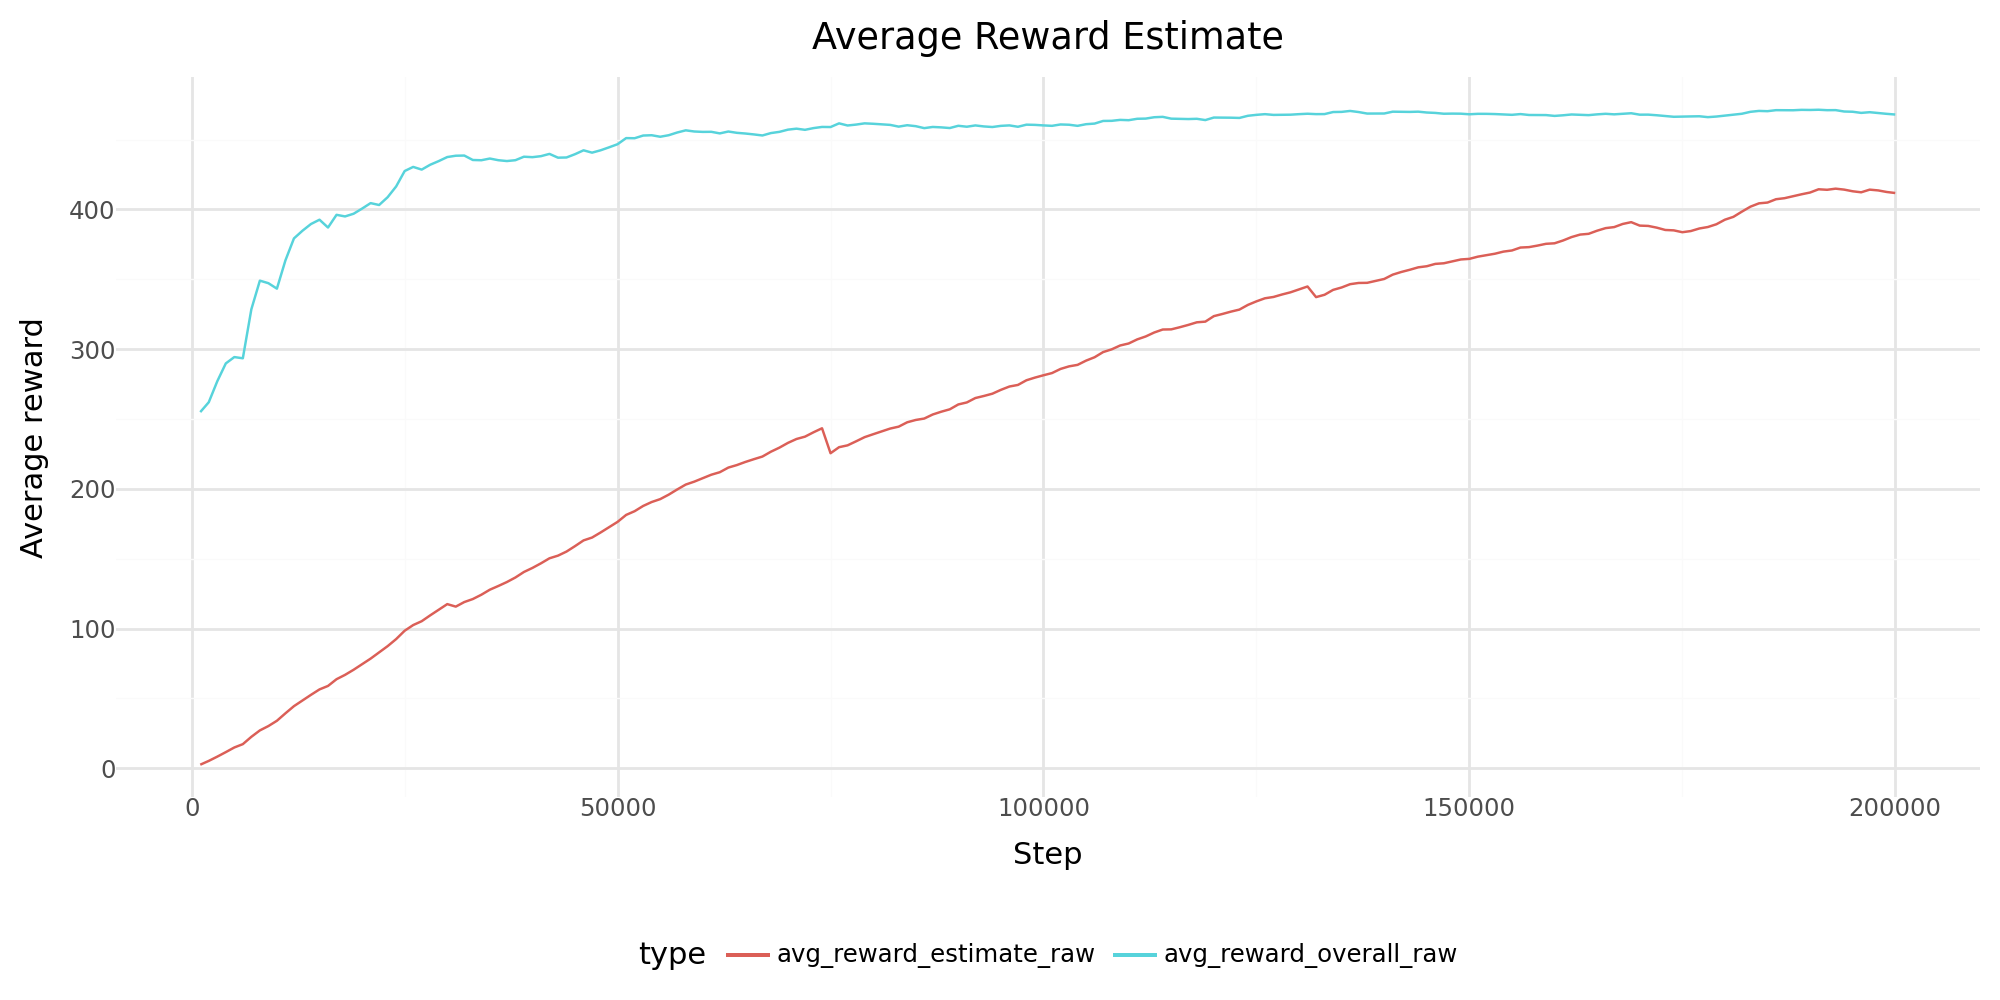

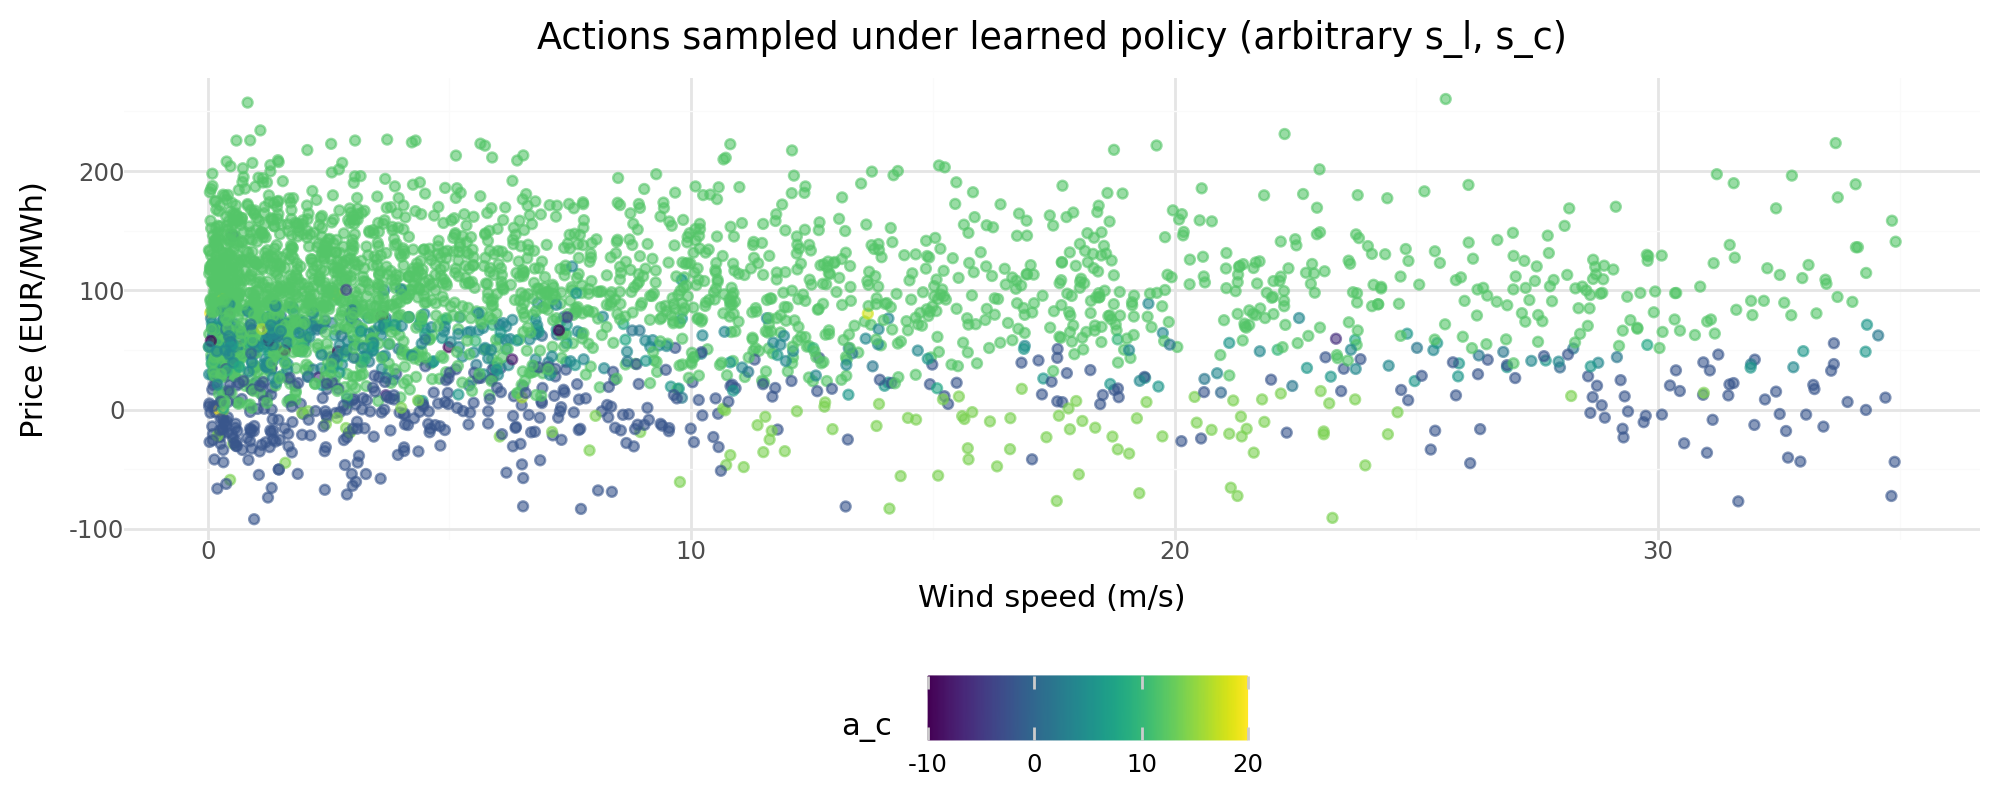

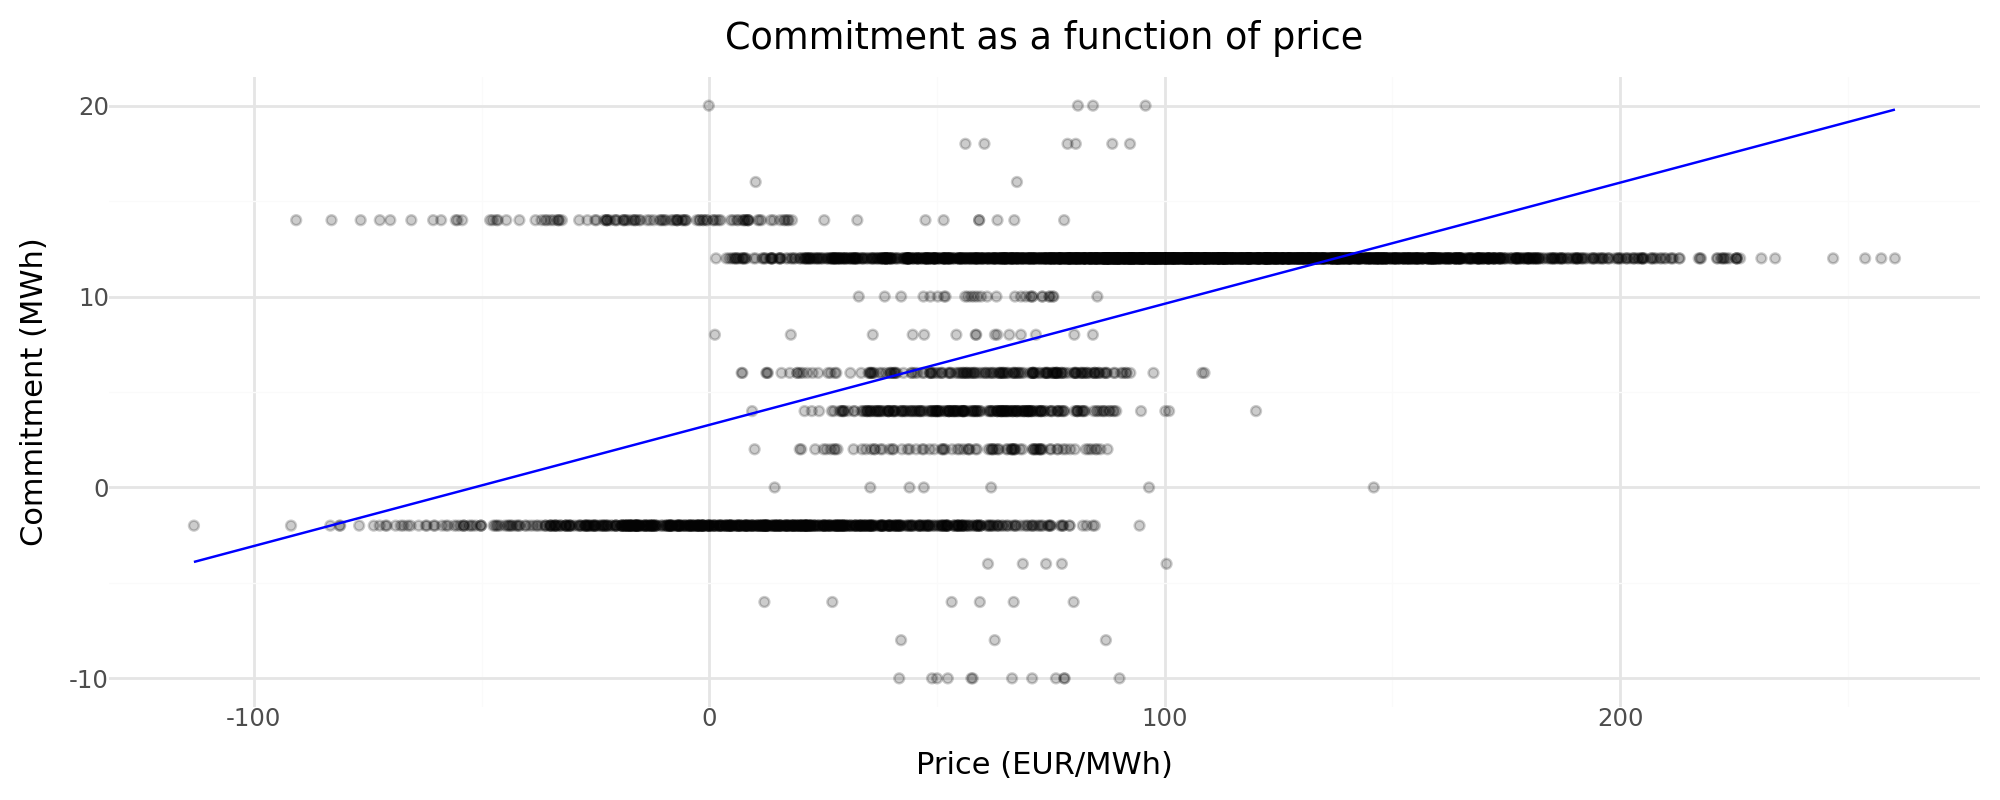

In [ ]:
#@title Run 1 and plot

# Hyperparameters (for scaled rewards):
alpha_theta = 1e-4    # actor lr (smaller because δ is O(1) after scaling)
alpha_v     = 1e-3    # critic lr
alpha_r     = 1e-5    # average reward lr
total_steps = 200_000



# Create actor and critic.
actor = SoftmaxActorAC(
    env=envD,
    step_size=alpha_theta,
    hidden_sizes=(64, 64),
    state_dim=4,
    device=DEVICE,
    max_grad_norm=1.0,
)

critic = ValueFunctionNN(
    state_dim=4,
    step_size=alpha_v,
    hidden_sizes=(64, 64),
    device=DEVICE,
    max_grad_norm=1.0,
)

# Create a global logger and a simple wrapper function
logger = ACLogger()
def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
    """Wrapper so actor_critic_continuing can call logger.callback."""
    logger.callback(pi_hat, info, trace)

# Train with differential actor–critic.
actor_critic_continuing(
    pi_hat=actor,
    v_hat=critic,
    steps=total_steps,
    alpha_r=alpha_r,
    r_bar_ini=0.0,
    reward_scale=1000.0,   # adjust if reward magnitudes change
    callback=ac_callback,
    callback_every=1000,
)

# Plot results and rollouts.
plot_results(actor, critic, logger, steps=4_000)


A few comments to the plots:

* The average reward estimate of the current policy is approx. 250 EUR/h
* Based on the second plot, the policy appears to be as expected. We mostly buy when the price is negative and sell when the price is positive. As wind speeds increase, we sell more. However, with wind speeds above 30, we would not produce energy. This does not seem to be estimated accurately.
* The third plot show that, as price increase we commit more on average.

As can be seen below. Using other hyperparameters may give different results.


Training (AC):   0%|          | 0/200000 [00:00<?, ?it/s]

Step 1000 | overall sample reward=227.00 | r_bar=21.56
Step 2000 | overall sample reward=261.04 | r_bar=48.94
Step 3000 | overall sample reward=262.26 | r_bar=70.52
Step 4000 | overall sample reward=272.64 | r_bar=95.15
Step 5000 | overall sample reward=271.99 | r_bar=115.72
Step 6000 | overall sample reward=259.73 | r_bar=122.17
Step 7000 | overall sample reward=286.01 | r_bar=151.89
Step 8000 | overall sample reward=301.85 | r_bar=176.66
Step 9000 | overall sample reward=295.58 | r_bar=184.90
Step 10000 | overall sample reward=286.06 | r_bar=186.25
Step 11000 | overall sample reward=303.35 | r_bar=214.01
Step 12000 | overall sample reward=315.88 | r_bar=238.88
Step 13000 | overall sample reward=320.25 | r_bar=251.97
Step 14000 | overall sample reward=323.51 | r_bar=266.68
Step 15000 | overall sample reward=323.47 | r_bar=272.37
Step 16000 | overall sample reward=311.31 | r_bar=259.67
Step 17000 | overall sample reward=301.29 | r_bar=248.95
Step 18000 | overall sample reward=289.79 | 

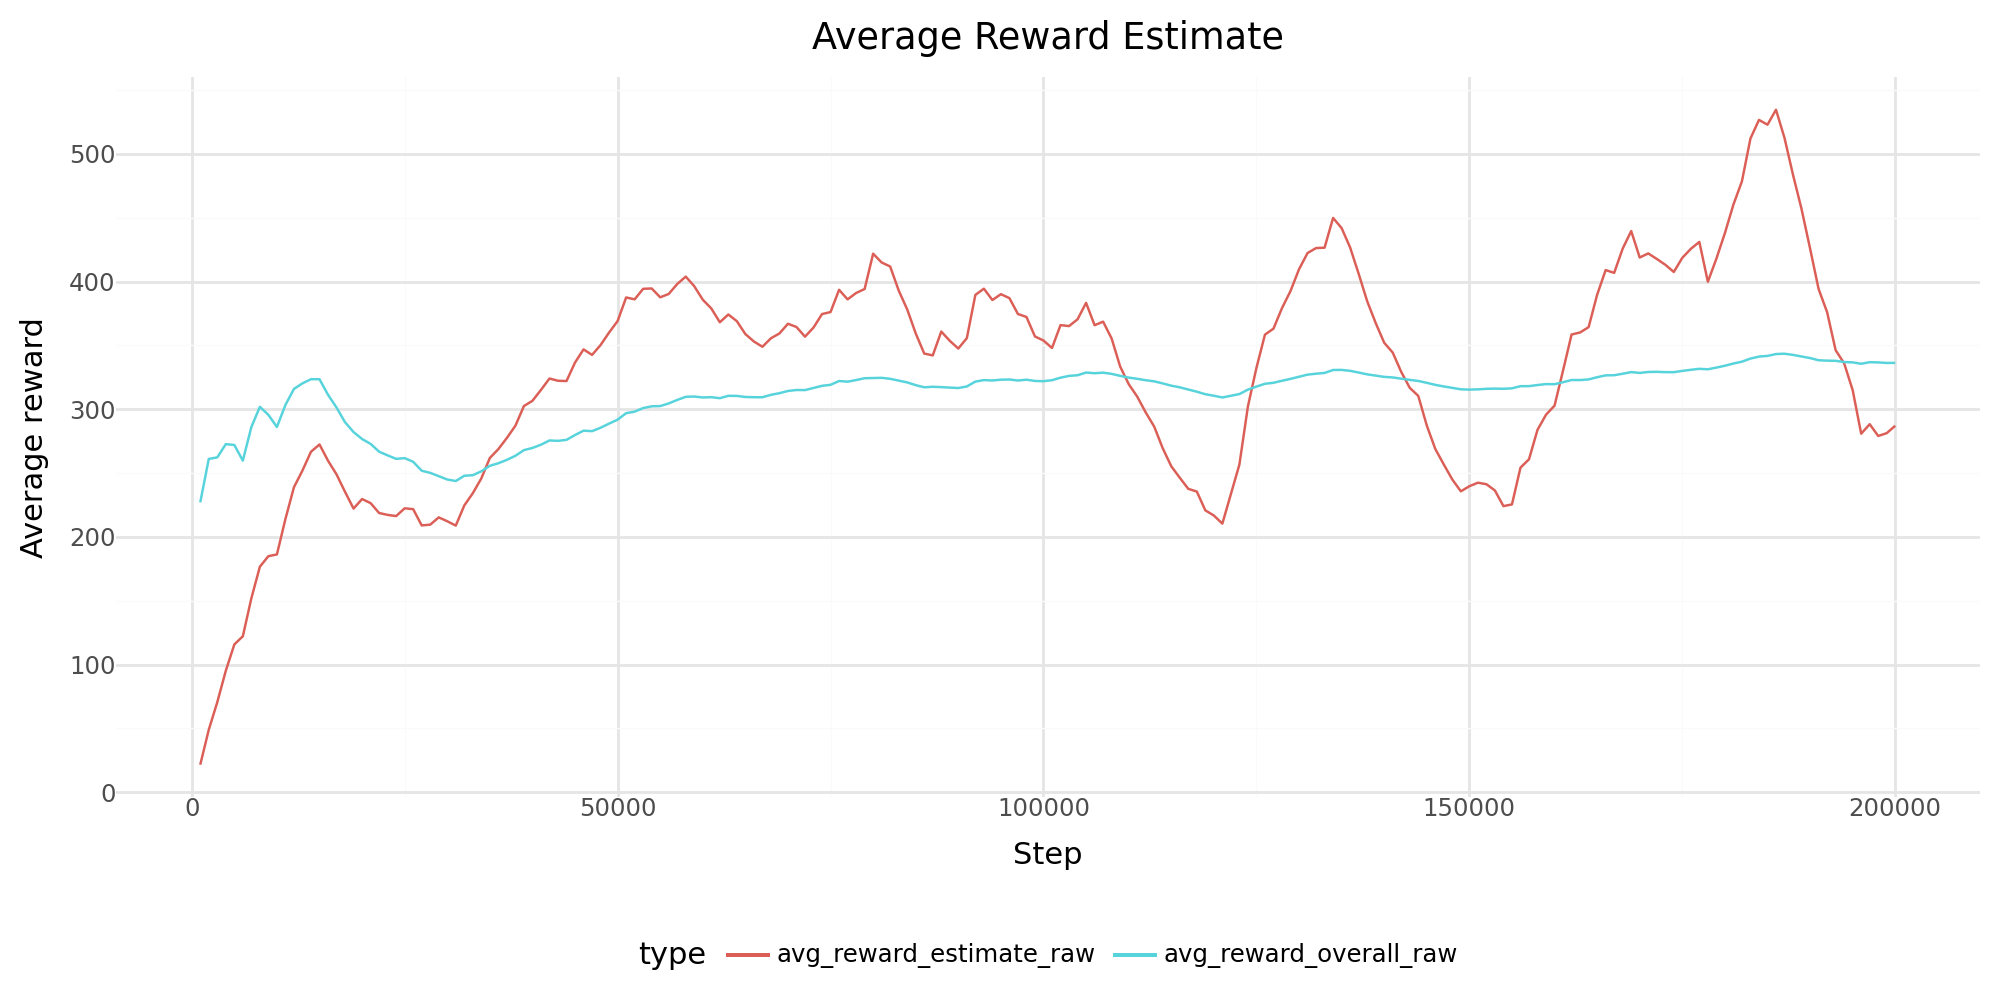

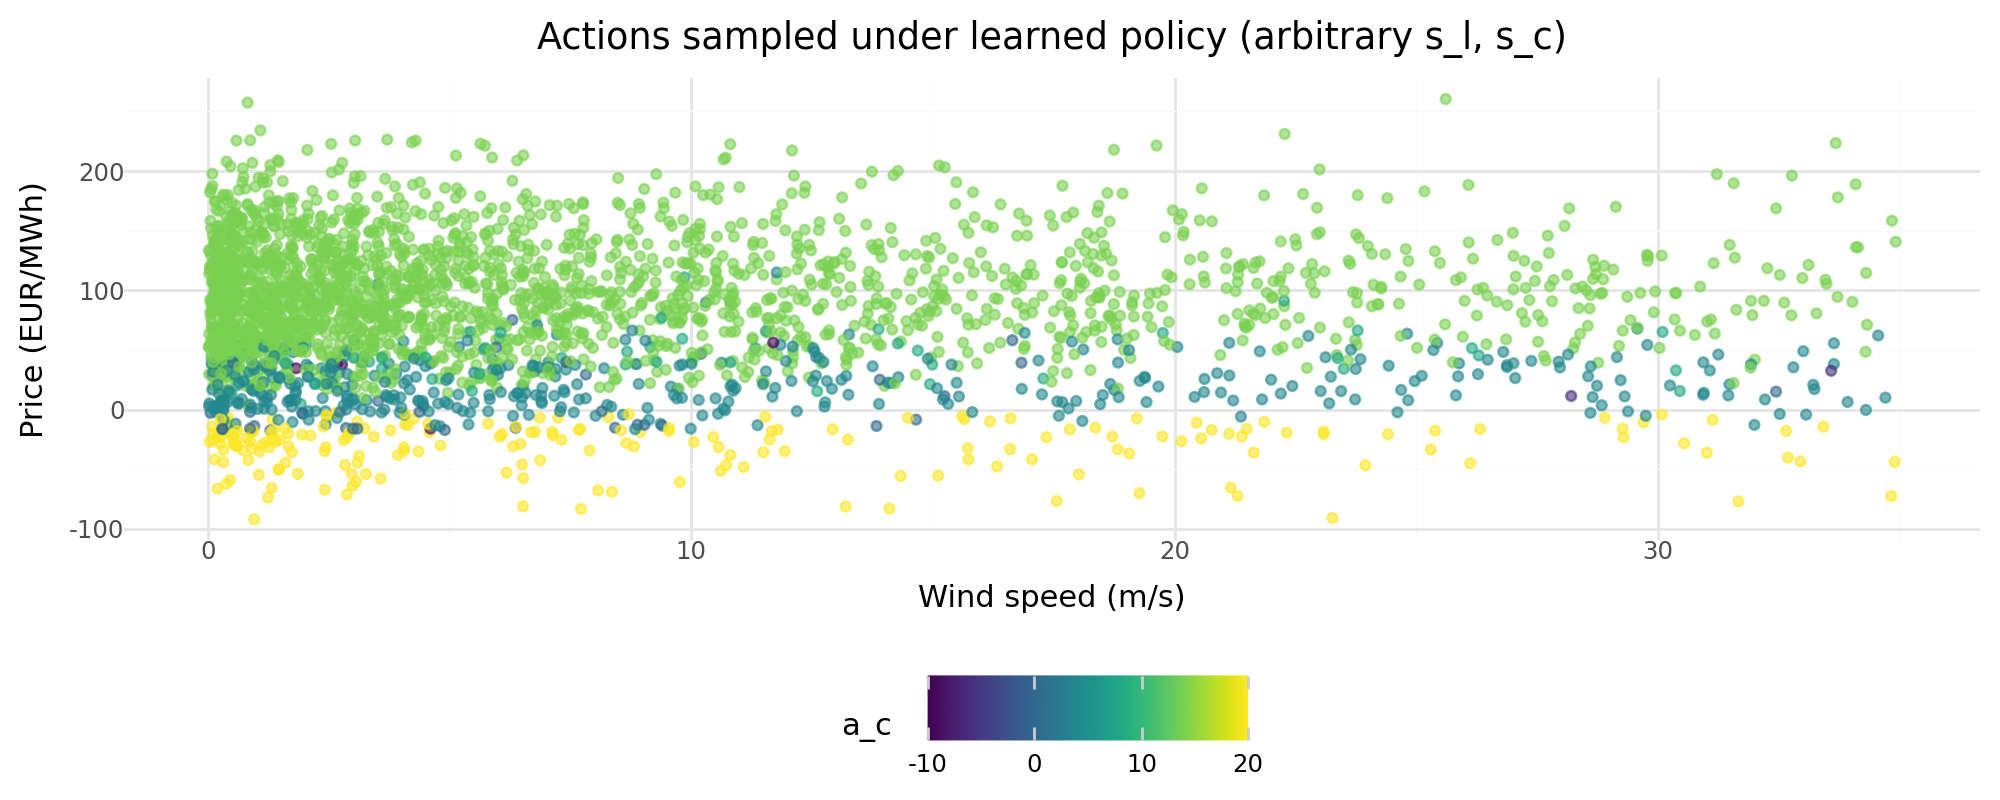

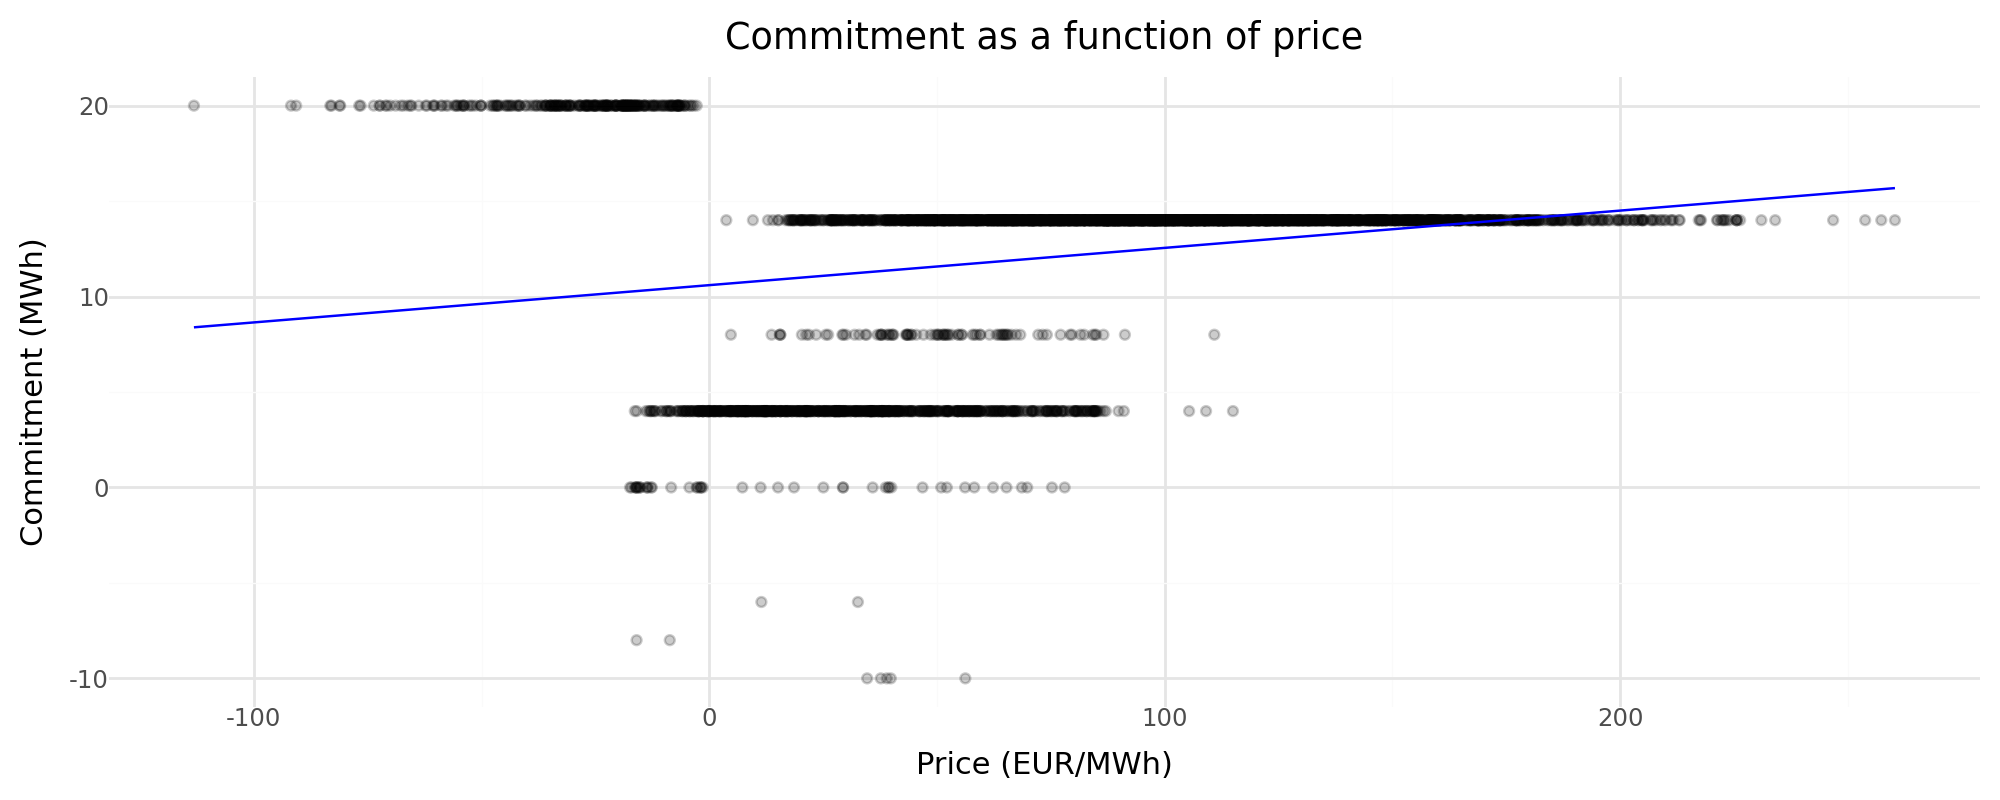

In [12]:
#@title Run 2 and plot

# Hyperparameters (for scaled rewards):
alpha_v     = 1e-3    # critic lr
alpha_theta = alpha_v / 2    # actor lr
alpha_r     = 1e-4     # average reward lr
total_steps = 200000

# Create actor and critic.
actor = SoftmaxActorAC(
    env=envD,
    step_size=alpha_theta,
    hidden_sizes=(64, 64),
    state_dim=4,
    device=DEVICE,
    max_grad_norm=1.0,
)

critic = ValueFunctionNN(
    state_dim=4,
    step_size=alpha_v,
    hidden_sizes=(64, 64),
    device=DEVICE,
    max_grad_norm=1.0,
)

# Create a global logger and a simple wrapper function
logger = ACLogger()
def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
    """Wrapper so actor_critic_continuing can call logger.callback."""
    logger.callback(pi_hat, info, trace)

# Train with differential actor–critic.
actor_critic_continuing(
    pi_hat=actor,
    v_hat=critic,
    steps=total_steps,
    alpha_r=alpha_r,
    r_bar_ini=0.0,
    reward_scale=1000.0,   # adjust if reward magnitudes change
    callback=ac_callback,
    callback_every=1000,
)

# Plot results and rollouts.
plot_results(actor, critic, logger, steps=4_000)


## Solution using continuous actions





We apply an actor-critic algorithm using neural networks for the policy and value approximations. We use PyTorch for representing the neural networks.

Here we first convert the environment into a gymnasium environment that samples the 4-dim state-space in a box (upper and lower bounds) and uses normalization for states and actions.

In [ ]:
#@title Gymnasium environment wrapper

class EnergyMarketAvgEnv(gym.Env):
    """Gymnasium wrapper exposing EnvEnergyCont as a standard RL environment.

    Observation:
        Box(4,) with (s_l, s_c, s_w, s_p).

    Action:
        Box(1,) with scalar x in [-1, 1] which is mapped to a contract a_c
        in [a_c_min(s), c_max]. The EnvEnergyCont then computes a_b and a_w.
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        settings: Dict[str, float],
        max_steps: int = 1_000,
        seed: int = 25_328,
    ) -> None:
        """Initializes Gymnasium environment.

        Args:
            settings: Environment parameters passed to EnvEnergyCont.
            max_steps: Artificial episode length for truncation.
            seed: RNG seed used in the core environment.
        """
        super().__init__()

        self.settings = settings
        self.max_steps = max_steps
        self.env_core = EnvEnergyCont(settings=settings, seed=seed)

        b_max = settings["b_max"]
        c_max = settings["c_max"]
        w_max = settings.get("w_max", settings.get("w_cut_out", 35.0))
        p_abs = settings.get("p_abs_max", 200.0)

        # Continuous state bounds.
        obs_low = np.array([0.0, -b_max, 0.0, -p_abs], dtype=np.float32)
        obs_high = np.array([b_max, c_max, w_max, p_abs], dtype=np.float32)
        self.observation_space = spaces.Box(
            obs_low,
            obs_high,
            dtype=np.float32,
        )

        # Action is a scalar in [-1, 1]; we map it internally to a_c.
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32,
        )

        self._state: np.ndarray | None = None
        self._step_count = 0

    def _map_action_to_a_c(
        self,
        x: float,
        state: np.ndarray,
    ) -> Tuple[float, float, float, float]:
        """Maps normalized action x in [-1, 1] to (a_b, a_w, a_c_min, a_c).

        Args:
            x: Normalized action in [-1, 1].
            state: Current state array.

        Returns:
            Tuple (a_b, a_w, a_c_min, a_c).
        """
        a_b, a_w, a_c_min = self.env_core.get_action_info(tuple(state))
        a_c_min = float(a_c_min)
        c_max = float(self.settings["c_max"])

        # Clip to valid range, then affine map to [a_c_min, c_max].
        x_clipped = float(np.clip(x, -1.0, 1.0))
        a_c = a_c_min + (x_clipped + 1.0) * 0.5 * (c_max - a_c_min)

        return a_b, a_w, a_c_min, a_c

    def reset(
        self,
        *,
        seed: int | None = None,
        options: Dict[str, Any] | None = None,
    ) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Resets the environment to a default starting state.

        Args:
            seed: Optional seed for reproducibility.
            options: Unused Gymnasium options dict.

        Returns:
            Observation array and an empty info dict.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.env_core.reset_rng(seed)

        self._step_count = 0

        b_max = self.settings["b_max"]
        # Start from half-charged battery and no contract.
        s_l0 = 0.5 * b_max
        s_c0 = 0.0
        s_w0 = self.settings.get("w_init", 8.0)
        s_p0 = self.settings.get("p_init", 20.0)

        self._state = np.array([s_l0, s_c0, s_w0, s_p0], dtype=np.float32)

        return self._state.copy(), {}

    def step(
        self,
        action: np.ndarray,
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, float]]:
        """Applies one step given a normalized action.

        Args:
            action: Array of shape (1,) with scalar in [-1, 1].

        Returns:
            Tuple (obs, reward, terminated, truncated, info).
        """
        self._step_count += 1
        assert self._state is not None
        state = self._state

        # Map scalar action to actual contract a_c and fixed a_b, a_w.
        a_b, a_w, a_c_min, a_c = self._map_action_to_a_c(float(action[0]), state)

        next_state, reward = self.env_core.get_step(
            tuple(state),
            (a_b, a_w, a_c),
        )
        self._state = np.array(next_state, dtype=np.float32)

        terminated = False  # underlying process is continuing
        truncated = self._step_count >= self.max_steps

        info = {
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
            "a_c_min": a_c_min,
        }

        return self._state.copy(), reward, terminated, truncated, info

    def render(self) -> None:
        """Prints the current state to stdout."""
        print(self._state)

    def close(self) -> None:
        """Cleans up resources (no-op here)."""
        return


We use PyTorch for representing the neural networks.

* `Critic`: Differential value function approximator. Neural network with 2 hidden layers for calculating the baseline $v(s)$. That is, we approximate $v(s)$ using a NN instead of linear features.
* `SquashedGaussianActor`: Gaussian policy network with tanh squashing (so normalised).

In [ ]:
#@title Policy and state-value approximations (NN)

class SquashedGaussianActor(nn.Module):
    """Gaussian policy with tanh squashing to keep actions in [-1, 1]."""

    def __init__(
        self,
        obs_dim: int,
        act_dim: int,
        hidden_size: int = 64,
        log_std_bounds: Tuple[float, float] = (-5.0, 2.0),
    ) -> None:
        """Initializes the actor network.

        Args:
            obs_dim: Dimension of observation vector.
            act_dim: Dimension of action vector.
            hidden_size: Size of hidden layers.
            log_std_bounds: Min and max for log standard deviation.
        """
        super().__init__()

        # Two-layer MLP trunk.
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )

        # Output heads for mean and log-std of Gaussian.
        self.mu_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_bounds = log_std_bounds

    def forward(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes Gaussian parameters for given observations.

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Tuple (mu, std) with shape (batch, act_dim).
        """
        x = self.net(obs)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)

        # Clamp log_std to avoid numerical issues.
        log_std = torch.clamp(
            log_std,
            self.log_std_bounds[0],
            self.log_std_bounds[1],
        )
        std = log_std.exp()

        return mu, std

    def sample(
        self,
        obs: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Samples actions and computes log-probabilities.

        The policy is:
            z ~ Normal(mu, std)
            a = tanh(z)
        which keeps a in [-1, 1].

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Tuple (action, log_prob):
                action: Tensor in [-1, 1], shape (batch, act_dim).
                log_prob: Tensor, shape (batch,).
        """
        mu, std = self(obs)
        dist = Normal(mu, std)

        # Reparameterization trick for gradient flow.
        z = dist.rsample()
        action = torch.tanh(z)

        # Log-prob with tanh correction term.
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1)

        return action, log_prob


class Critic(nn.Module):
    """Differential value function v_w(s) (a.k.a. h(s))."""

    def __init__(self, obs_dim: int, hidden_size: int = 64) -> None:
        """Initializes the critic network.

        Args:
            obs_dim: Dimension of observation vector.
            hidden_size: Size of hidden layers.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """Computes value estimates v(s).

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Value tensor, shape (batch,).
        """
        return self.net(obs).squeeze(-1)


Next, we modify the actor-critic algorithm so fit the gym environment setting

In [ ]:
#@title Differential (average-reward) actor–critic

def train_differential_ac(
    env: gym.Env,
    steps: int = 200_000,
    actor_lr: float = 1e-4,
    critic_lr: float = 1e-3,
    alpha_r: float = 1e-3,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1_000.0,
    callback: Any | None = None,
    callback_every: int = 0,
    trace: Any | None = None,
    print_every: int = 0,
    device: str = "cpu",
) -> Tuple[SquashedGaussianActor, Critic, torch.Tensor]:
    """Runs differential (average-reward) actor–critic with reward scaling.

    Uses scaled rewards:
        R_scaled = R_raw / reward_scale
        δ_t = R_scaled - r̄_t + v(s_{t+1}) - v(s_t)

    Actor update:
        θ ← θ + α_θ δ_t ∇_θ log π(a_t | s_t)

    Critic (semi-gradient TD(0)):
        w ← w + α_v δ_t ∇_w v(s_t)

    Average reward (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        env: Gymnasium environment (EnergyMarketAvgEnv).
        steps: Number of training steps.
        actor_lr: Learning rate for actor.
        critic_lr: Learning rate for critic.
        alpha_r: Step size for average reward update.
        r_bar_ini: Initial average reward estimate (scaled).
        reward_scale: Divisor for raw rewards to stabilize learning.
        callback: Optional function called periodically with logging info.
        callback_every: Interval (in steps) for calling callback.
        trace: Optional object passed through to callback (unused here).
        print_every: Interval (in steps) for console logging (0 disables).
        device: Torch device string ("cpu" or "cuda").

    Returns:
        Tuple (actor, critic, r_bar) where r_bar is the final avg reward
        estimate in scaled units.
    """
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    actor = SquashedGaussianActor(obs_dim, act_dim).to(device)
    critic = Critic(obs_dim).to(device)

    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    # Average reward estimate r̄ in scaled units.
    r_bar = torch.tensor(r_bar_ini, dtype=torch.float32, device=device)

    # Initial observation.
    obs_np, _ = env.reset()
    obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

    # Running sums for logging scaled and raw rewards.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    # Exponentially smoothed reward for quick prints.
    running_reward = 0.0

    for step in tqdm(range(1, steps + 1), desc="Training (PyTorch AC)"):
        # 1) Sample action from policy given current observation.
        action_tensor, log_prob = actor.sample(obs.unsqueeze(0))
        action = action_tensor.detach().cpu().numpy()[0]

        # 2) Step the environment and receive raw reward.
        next_obs_np, reward_raw, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # 3) Scale reward to keep TD errors in a reasonable range.
        reward_scaled = reward_raw / reward_scale

        # 4) Compute critic values v(s) and v(s').
        next_obs = torch.as_tensor(next_obs_np, dtype=torch.float32, device=device)
        v_s = critic(obs)
        v_next = critic(next_obs).detach()

        # 5) Differential TD error δ_t in scaled units.
        delta_t = reward_scaled - r_bar.item() + (v_next.item() - v_s.item())
        delta_t_tensor = torch.tensor(delta_t, dtype=torch.float32, device=device)

        # 6) Update average reward estimate r̄.
        r_bar = r_bar + alpha_r * delta_t_tensor

        # 7) Critic semi-gradient TD(0) update.
        critic_opt.zero_grad()
        critic_loss = -delta_t_tensor * v_s  # gradient ascent on δ_t * v(s)
        critic_loss.backward()
        critic_opt.step()

        # 8) Actor update using policy gradient with δ_t as multiplier.
        actor_opt.zero_grad()
        actor_loss = -log_prob.squeeze(0) * delta_t_tensor.detach()
        actor_loss.backward()
        actor_opt.step()

        # 9) Update logging accumulators.
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        running_reward = 0.99 * running_reward + 0.01 * reward_raw

        # 10) Optional callback for logging.
        if callback is not None and callback_every > 0 and step % callback_every == 0:
            info_dict = {
                "step": step,
                "reward_scale": reward_scale,
                "avg_reward_estimate_scaled": float(r_bar.item()),
                "avg_reward_estimate_raw": float(r_bar.item() * reward_scale),
                "avg_reward_overall_scaled": total_reward_scaled / step,
                "avg_reward_overall_raw": total_reward_raw / step,
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums but keep global sums.
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            # Match your earlier signature: callback(pi_hat, info, trace).
            # Here, pi_hat is the actor.
            callback(actor, info_dict, trace)

        # 11) Move to next state.
        obs = next_obs

        if done:
            obs_np, _ = env.reset()
            obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

        # Optional console logging.
        if print_every > 0 and step % print_every == 0:
            avg = total_reward_raw / step
            print(
                f"Step {step} | overall sample reward={avg:.2f} | "
                # f"r_bar_scaled={r_bar.item():.4f} | "
                f"r_bar={r_bar.item() * reward_scale:.2f}",
            )

    print(
        "Final average reward estimate:  ",
        round(r_bar.item() * reward_scale, 2),
    )

    return actor, critic, r_bar


We modify callback and plotting functions:

In [ ]:
#@title Callback + plots


def plot_results(
    env: gym.Env,
    actor: nn.Module,
    v_hat: Any,  # Unused but kept for API symmetry.
    logger_obj: ACLogger,
    steps: int = 4_000,
    device: str = "cpu",
) -> None:
    """Plots training curves and behavior of the learned policy.

    Steps:
      1. Extract training curves from logger_obj.
      2. Run a fresh trajectory under the current policy.
      3. Plot:
         * Average reward estimate (raw) over training steps.
         * (s_w, s_p) paired with commitments a_c.
         * a_c as a function of price s_p.

    Args:
        env: Gymnasium environment (EnergyMarketAvgEnv).
        actor: Trained policy network (SquashedGaussianActor).
        v_hat: Trained value function (unused).
        logger_obj: ACLogger instance holding training logs.
        steps: Number of steps for the rollout trajectory.
        device: Torch device string.
    """
    # 1) Training log dataframe (scaled + raw metrics).
    df_log = logger_obj.df()

    # 2) Collect a post-training trajectory.
    traj = TrajectoryRecorder()
    state, _ = env.reset()

    for step in tqdm(range(1, steps + 1), desc="Collecting trajectory"):
        obs_tensor = torch.as_tensor(
            state,
            dtype=torch.float32,
            device=device,
        ).unsqueeze(0)

        with torch.no_grad():
            action_tensor, _ = actor.sample(obs_tensor)

        # action in [-1, 1], map through env.step to physical a_b, a_w, a_c.
        action = action_tensor.cpu().numpy()[0]
        next_state, reward_raw, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        a_b = info["a_b"]
        a_w = info["a_w"]
        a_c = info["a_c"]

        traj.record(
            step=step,
            state=tuple(state),
            action=(a_b, a_w, a_c),
            reward=reward_raw,
        )

        state = next_state
        if done:
            state, _ = env.reset()

    df_traj = traj.df()

    # Common style settings for figures.
    plot_theme = theme_minimal() + theme(
        figure_size=(10, 4),
        legend_position="bottom",
    )

    # ------------------------------------------------------------------
    # Plot 1: Average reward estimate (raw) as training runs.
    # ------------------------------------------------------------------
    if "avg_reward_estimate_raw" in df_log.columns:
        cols_to_gather = [
            "avg_reward_estimate_raw",
            "avg_reward_overall_raw",
        ]
        dat_r = df_log >> gather("type", "r", cols_to_gather)

        pt = (
            ggplot(dat_r, aes("step", "r", color="type"))
            + geom_line()
            + theme_minimal()
            + theme(figure_size=(10, 5), legend_position="bottom")
            + labs(
                title="Average Reward Estimate (raw)",
                x="Training step",
                y="Average reward",
            )
        )
        pt.show()

    # ------------------------------------------------------------------
    # Plot 2: Actions in (wind, price)-space colored by commitment.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj >> mask(X.s_w < 35), aes("s_w", "s_p", color="a_c"))
        + geom_point(alpha=0.6)
        + labs(
            title="Actions sampled under learned policy",
            x="Wind speed (m/s)",
            y="Price (EUR/MWh)",
        )
        + plot_theme
    )
    pt.show()

    # ------------------------------------------------------------------
    # Plot 3: Commitment as function of price.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_p", "a_c"))
        + geom_point(alpha=0.2)
        + geom_smooth(
            span=0.1,
            se=False,
            color="blue",
            alpha=0.5,
            size=0.5,
        )
        + labs(
            title="Commitment as a function of price",
            x="Price (EUR/MWh)",
            y="Commitment (MWh)",
        )
        + plot_theme
    )
    pt.show()


Training (PyTorch AC):   0%|          | 0/200000 [00:00<?, ?it/s]

Step 5000 | overall sample reward=505.00 | r_bar=197.74
Step 10000 | overall sample reward=544.68 | r_bar=346.35
Step 15000 | overall sample reward=603.19 | r_bar=488.82
Step 20000 | overall sample reward=605.80 | r_bar=537.80
Step 25000 | overall sample reward=645.61 | r_bar=654.12
Step 30000 | overall sample reward=657.21 | r_bar=678.19
Step 35000 | overall sample reward=654.46 | r_bar=659.96
Step 40000 | overall sample reward=656.83 | r_bar=663.90
Step 45000 | overall sample reward=660.61 | r_bar=672.79
Step 50000 | overall sample reward=673.94 | r_bar=718.17
Step 55000 | overall sample reward=683.13 | r_bar=733.26
Step 60000 | overall sample reward=688.80 | r_bar=733.66
Step 65000 | overall sample reward=684.71 | r_bar=689.63
Step 70000 | overall sample reward=687.36 | r_bar=703.94
Step 75000 | overall sample reward=689.80 | r_bar=705.01
Step 80000 | overall sample reward=692.31 | r_bar=705.31
Step 85000 | overall sample reward=689.16 | r_bar=675.67
Step 90000 | overall sample rewa

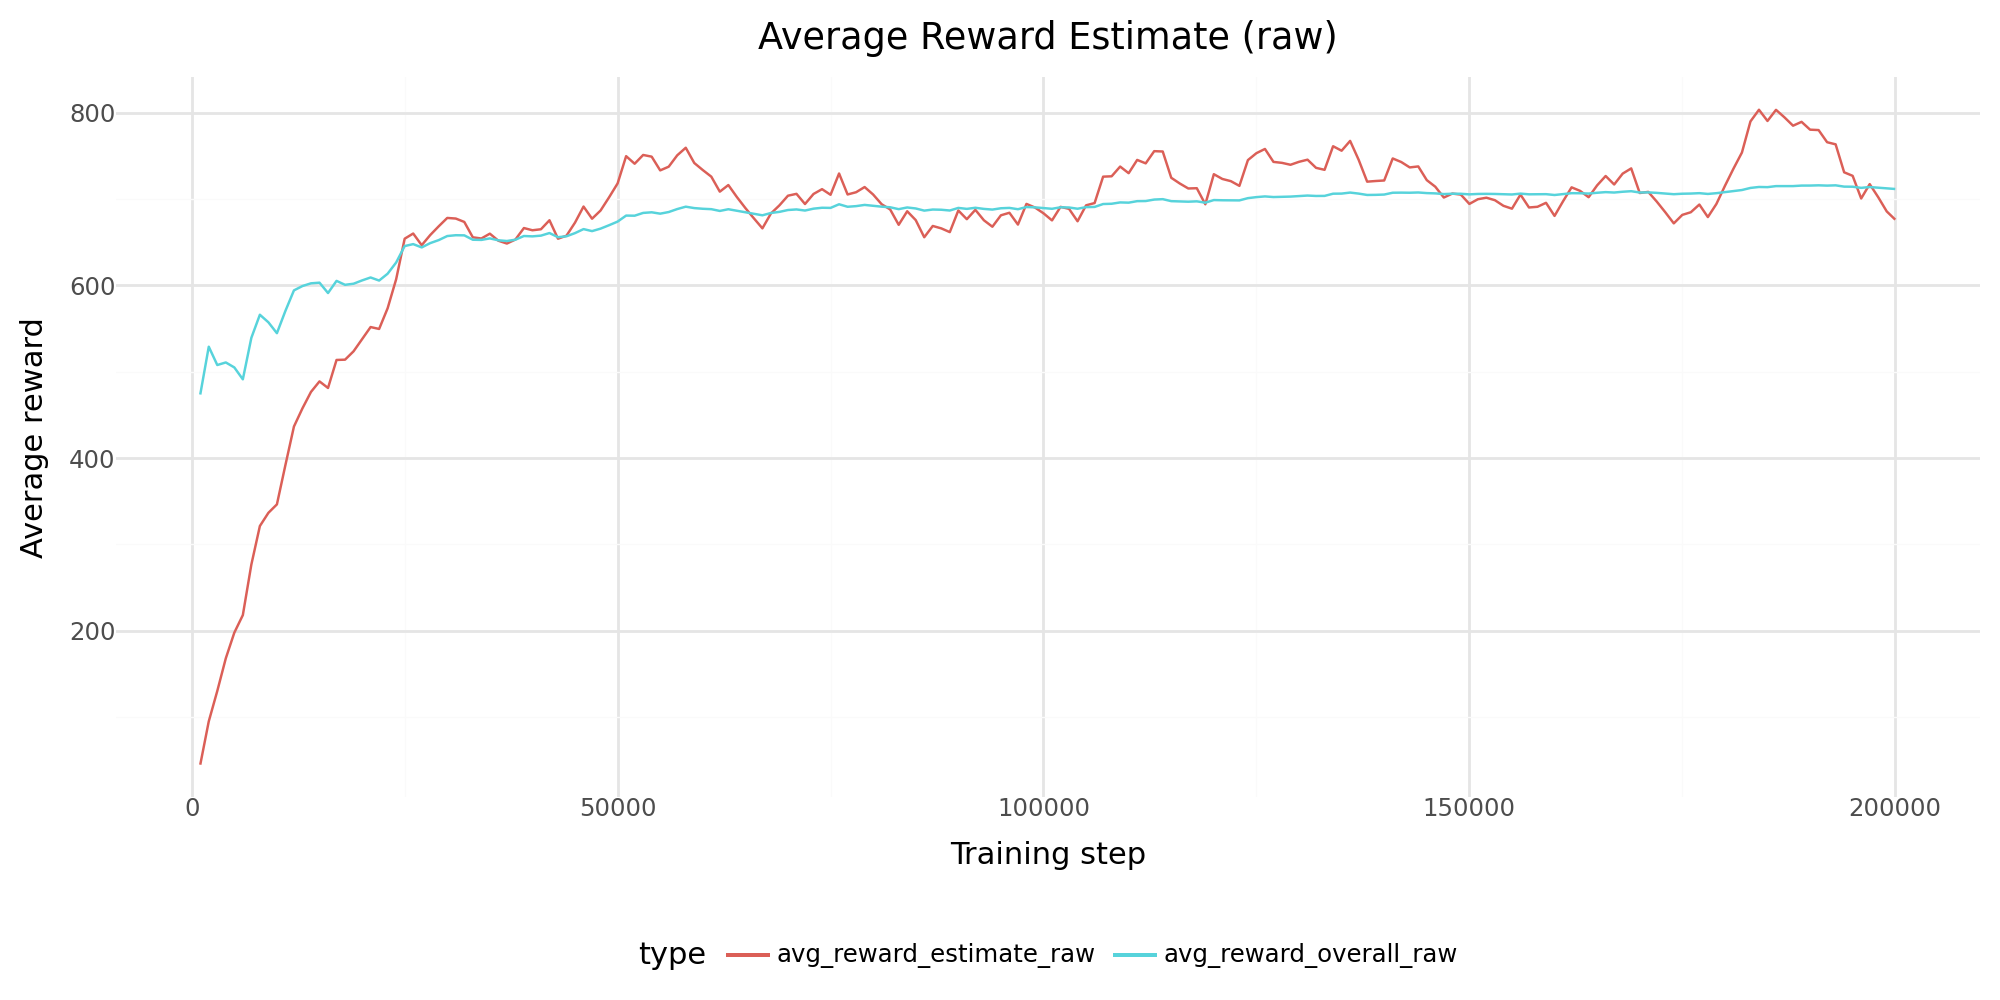

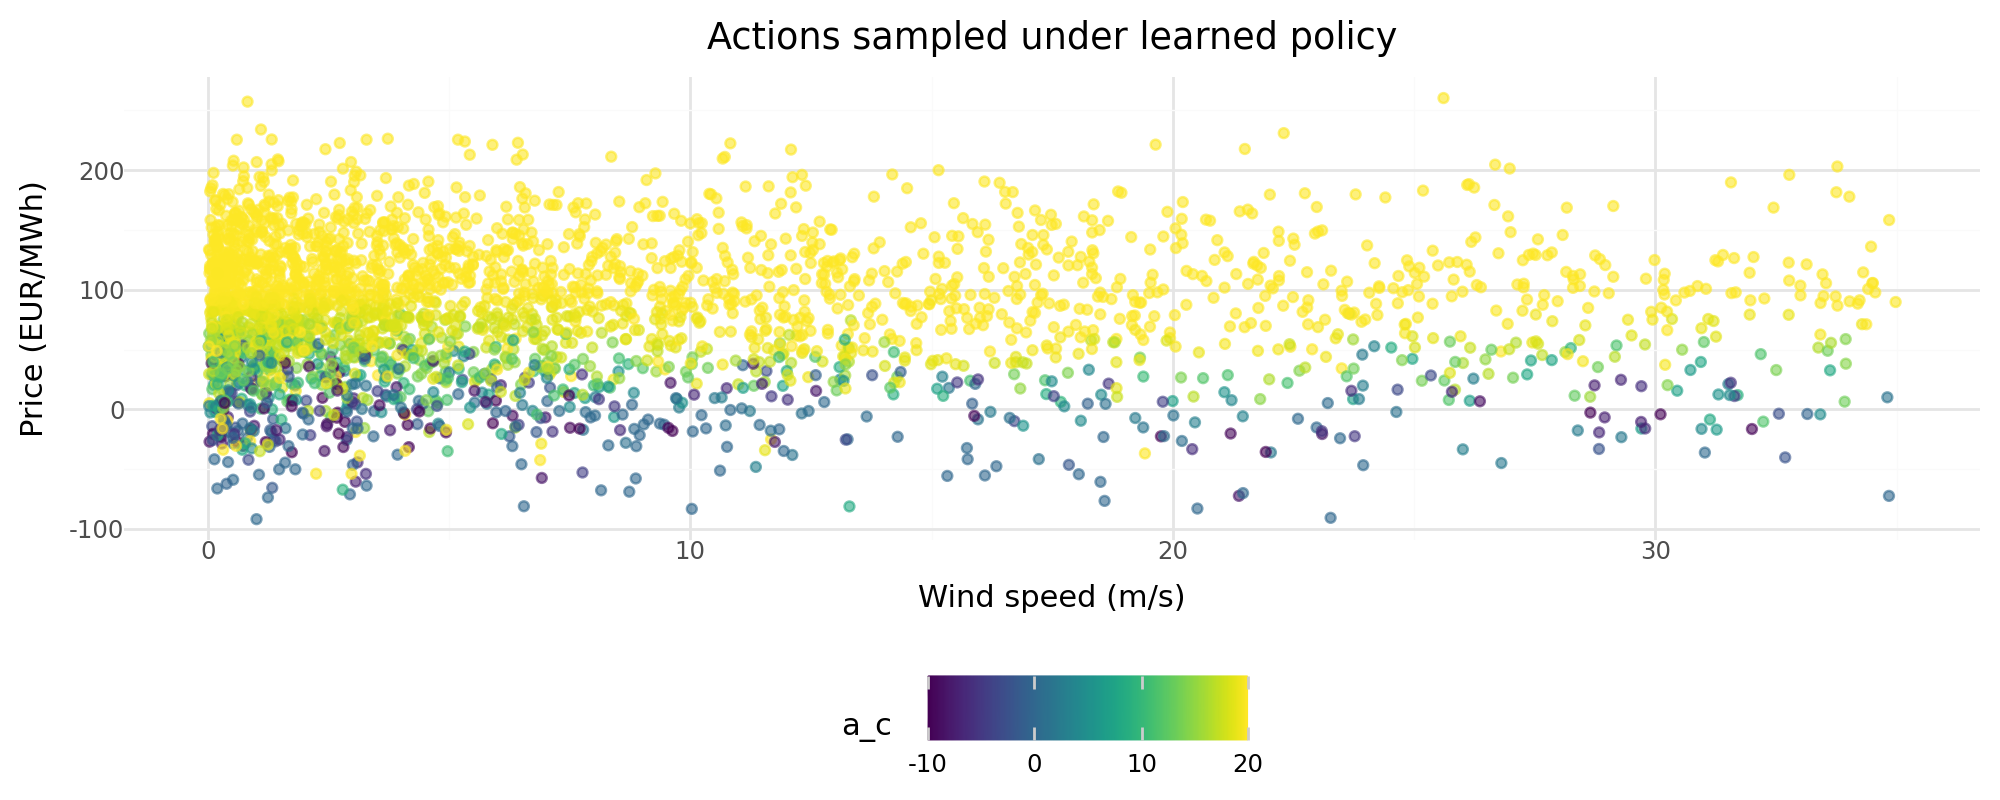

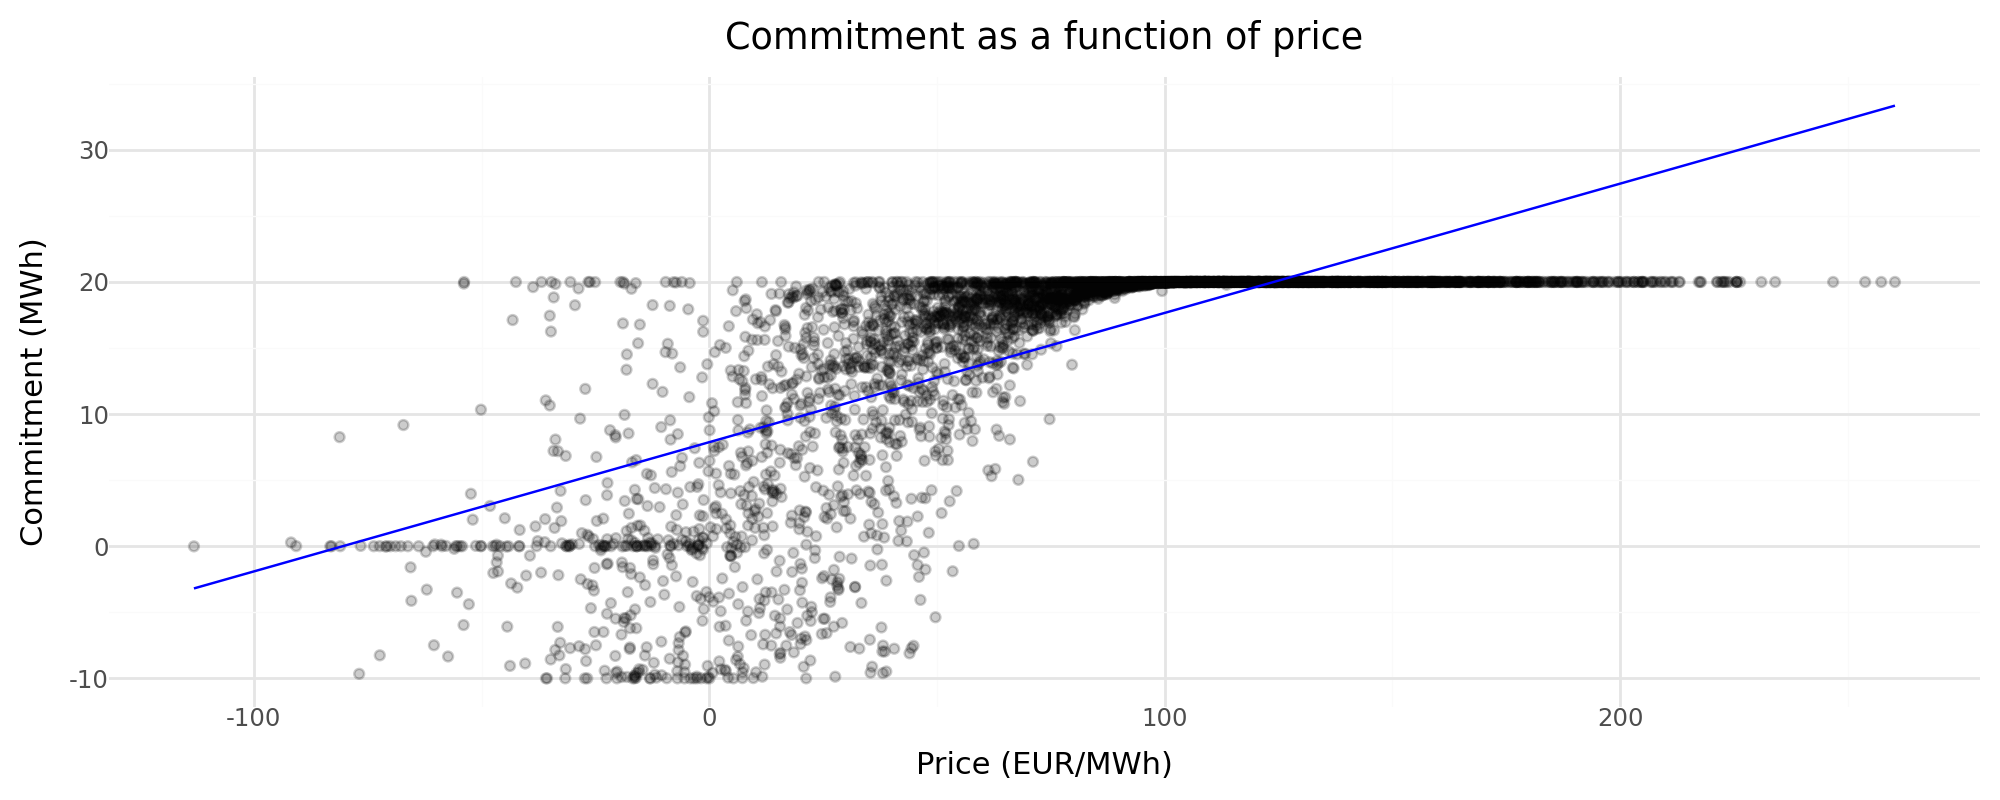

In [ ]:
#@title Run and plot

env = EnergyMarketAvgEnv(settings=settings, max_steps=5_000)

logger = ACLogger()

def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
    """Wrapper so train_differential_ac can log into ACLogger."""
    logger.callback(pi_hat, info, trace)

actor, critic, r_bar = train_differential_ac(
    env,
    steps=200_000,
    actor_lr=1e-4,
    critic_lr=1e-3,
    alpha_r=1e-4,
    r_bar_ini=0.0,
    reward_scale=1_000.0,
    callback=ac_callback,
    callback_every=1_000,
    print_every=5_000,
    device="cpu",
)

print(
    "Training finished. Final verage reward estimate:",
    r_bar.item() * 1_000.0,
)

plot_results(env, actor, critic, logger, steps=4_000, device="cpu")


A few comments to the plots:

* The average reward estimate of the current policy is approx. 675 EUR/h which is much higher than in the discrete case.
* Based on the second plot, the policy appears to be more aggressive. We mostly buy when the price is negative and sell when the price is positive. However, if price is above 50, we mostly commit fully.
Again, with wind speeds are above 30, we would not produce energy. Hence we would not be able to commit 20 if wind is above 30 in next period. This does not seem to be estimated accurately. It is problerly due to that we clip windspeeds above 35 in the model.
* The third plot show that, as price increase we commit more on average.


# Old


In [ ]:
#@title Full code discrete

"""
End-to-end actor–critic setup for EnvEnergyDiscrete with:
- Average-reward differential actor–critic
- Reward scaling for stability
- PyTorch neural-network actor and critic
- Logging (ACLogger)
- Trajectory recording (TrajectoryRecorder)
- Plotting with plotnine
"""

from typing import Any, Dict, List, Optional, Sequence, Tuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_point,
    geom_smooth,
    labs,
    theme_minimal,
    theme,
)
from tqdm.auto import tqdm


# =============================================================================
# Helper: device detection (works on Colab with T4 GPU)
# =============================================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =============================================================================
# NN/MLP builder
# =============================================================================

def build_mlp(
    input_dim: int,
    output_dim: int,
    hidden_sizes: Sequence[int] = (64, 64),
    activation: nn.Module = nn.Tanh,
) -> nn.Module:
    """Builds a simple fully connected neural network / Multilayer
    Perceptron (MLP) network.

    Args:
        input_dim: Input feature dimension.
        output_dim: Output dimension.
        hidden_sizes: Sizes of hidden layers.
        activation: Activation class (not instance), e.g. nn.ReLU.

    Returns:
        An nn.Sequential model.
    """
    layers: List[nn.Module] = []
    prev_dim = input_dim

    # Hidden layers: Linear -> activation for each hidden size.
    for hidden_size in hidden_sizes:
        layers.append(nn.Linear(prev_dim, hidden_size))
        layers.append(activation())
        prev_dim = hidden_size

    # Final linear layer (no activation): outputs scalar or logits.
    layers.append(nn.Linear(prev_dim, output_dim))

    return nn.Sequential(*layers)


# =============================================================================
# Value function v(s; w) – critic
# =============================================================================

class ValueFunctionNN:
    """Neural value function v(s) for continuing tasks.

    This critic is compatible with actor_critic_continuing():

        - eval(state) -> float
        - train(state, target) -> updates parameters toward target

    Attributes:
        state_dim: Dimension of the state vector.
        device: Torch device used for computation.
        net: Neural network approximating v(s).
        optimizer: Optimizer for network parameters.
    """

    def __init__(
        self,
        state_dim: int,
        step_size: float,
        hidden_sizes: Sequence[int] = (64, 64),
        device: Optional[torch.device] = None,
        max_grad_norm: float = 1.0,
    ) -> None:
        """Initializes the ValueFunctionNN.

        Args:
            state_dim: Dimension of the state vector.
            step_size: Learning rate for the optimizer.
            hidden_sizes: Sizes of hidden layers.
            device: Torch device; if None, auto-detects CPU/GPU.
            max_grad_norm: If > 0, clips gradients to this norm.
        """
        self.state_dim = state_dim
        self.device = device if device is not None else DEVICE
        self.max_grad_norm = max_grad_norm

        # State -> scalar value v(s).
        self.net = build_mlp(
            input_dim=state_dim,
            output_dim=1,
            hidden_sizes=hidden_sizes,
        ).to(self.device)

        # Adam optimizer with given step size.
        self.optimizer = optim.Adam(self.net.parameters(), lr=step_size)

    def _state_to_tensor(self, state: Any) -> torch.Tensor:
        """Converts a state to a [1, state_dim] float32 tensor on self.device."""
        if isinstance(state, (list, tuple, np.ndarray)):
            arr = np.asarray(state, dtype=np.float32).reshape(1, -1)
        else:
            raise TypeError(f"Unsupported state type: {type(state)}")

        return torch.from_numpy(arr).to(self.device)

    def eval(self, state: Any) -> float:
        """Evaluates v(s) as a Python float.

        Args:
            state: Environment state (list, tuple, or np.ndarray).

        Returns:
            Scalar value estimate v(s).
        """
        self.net.eval()
        with torch.no_grad():
            x = self._state_to_tensor(state)  # Shape: [1, state_dim]
            value_tensor = self.net(x)        # Shape: [1, 1]

        return float(value_tensor.item())

    def train(self, state: Any, target: float) -> None:
        """Performs a semi-gradient TD(0) update toward the target.

        Args:
            state: Environment state.
            target: TD target, e.g. v(s) + delta_t (in scaled reward units).
        """
        self.net.train()

        # Convert state and target to tensors.
        x = self._state_to_tensor(state)  # [1, state_dim]
        target_tensor = torch.tensor(
            [[target]],
            dtype=torch.float32,
            device=self.device,
        )

        # Forward pass: current value estimate.
        value_tensor = self.net(x)  # [1, 1]

        # Squared error loss: 0.5 * (v - target)^2.
        loss = 0.5 * (value_tensor - target_tensor).pow(2).mean()

        # Standard PyTorch update: zero grad -> backprop -> step.
        self.optimizer.zero_grad()
        loss.backward()

        # Optional gradient clipping for stability.
        if self.max_grad_norm is not None and self.max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(self.net.parameters(),
                                           max_norm=self.max_grad_norm)

        self.optimizer.step()


# =============================================================================
# Softmax policy π(a | s; θ) over discrete a_c – actor
# =============================================================================

class SoftmaxActorAC:
    """Softmax policy over discrete a_c values for EnvEnergyDiscrete.

    The environment is assumed to provide:

        * env.a_c_tuple: Tuple/list of all possible a_c (commitment) values.
        * env.get_actions(s): Returns a list of feasible (a_b, a_w, a_c) actions
          for the given state s.

    This actor:

        * Maintains a neural network that maps a state s to logits over ALL
          possible a_c values in env.a_c_tuple.
        * At a given state s, obtains the feasible actions from env.get_actions(s),
          filters the logits to the corresponding a_c values, and constructs a
          masked softmax distribution over these feasible actions.
        * Samples from that distribution in get_action(s).
        * For training, recomputes log π(a | s) and applies the standard policy
          gradient update with multiplier `mult` (usually delta_t).

    Attributes:
        env: Environment, e.g. EnvEnergyDiscrete.
        state_dim: Dimension of state vector.
        device: Torch device used for computation.
        a_c_values: List of all possible a_c values.
        num_actions_total: Number of distinct a_c values.
        a_c_to_index: Mapping from a_c value to global index.
        net: Neural network mapping state to logits over all a_c values.
        optimizer: Optimizer for network parameters.
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        hidden_sizes: Sequence[int] = (64, 64),
        state_dim: int = 4,
        device: Optional[torch.device] = None,
        max_grad_norm: float = 1.0,
    ) -> None:
        """Initializes the softmax actor.

        Args:
            env: Environment instance with a_c_tuple and get_actions(s).
            step_size: Learning rate for the actor (α_θ).
            hidden_sizes: Sizes of hidden layers in the policy network.
            state_dim: Dimension of the state vector.
            device: Torch device; if None, auto-detects CPU/GPU.
            max_grad_norm: If > 0, clips gradients to this norm.
        """
        self.env = env
        self.state_dim = state_dim
        self.device = device if device is not None else DEVICE
        self.max_grad_norm = max_grad_norm

        # Store all distinct commitment levels (global discrete action set).
        self.a_c_values: List[float] = [
            float(a_c) for a_c in self.env.a_c_tuple
        ]
        self.num_actions_total = len(self.a_c_values)

        # Map from a_c value to an index [0, num_actions_total).
        self.a_c_to_index: Dict[float, int] = {
            a_c: idx for idx, a_c in enumerate(self.a_c_values)
        }

        # Policy network: state -> logits over ALL a_c values.
        self.net = build_mlp(
            input_dim=self.state_dim,
            output_dim=self.num_actions_total,
            hidden_sizes=hidden_sizes,
        ).to(self.device)

        # Adam optimizer with given step size.
        self.optimizer = optim.Adam(self.net.parameters(), lr=step_size)

    def _state_to_tensor(self, state: Any) -> torch.Tensor:
        """Converts a state to a [1, state_dim] float32 tensor on self.device."""
        if isinstance(state, (list, tuple, np.ndarray)):
            arr = np.asarray(state, dtype=np.float32).reshape(1, -1)
        else:
            raise TypeError(f"Unsupported state type: {type(state)}")

        return torch.from_numpy(arr).to(self.device)

    def _feasible_actions_and_logits(
        self,
        state: Any,
    ) -> Tuple[List[Tuple[float, float, float]], torch.Tensor]:
        """Returns feasible actions and corresponding logits.

        For a given state, we:

            1. Query env.get_actions(state) -> list of (a_b, a_w, a_c).
            2. Run the policy network to obtain logits over all a_c values.
            3. Gather only the logits for those a_c values that appear among
               the feasible actions.

        Args:
            state: Environment state.

        Returns:
            A tuple (actions_list, logits_allowed) where:
                actions_list: List of feasible (a_b, a_w, a_c) actions.
                logits_allowed: 1D tensor of logits for these actions.
        """
        # Feasible actions from the environment.
        actions_list = self.env.get_actions(state)

        if not actions_list:
            raise RuntimeError("No feasible actions in env.get_actions(state).")

        self.net.eval()
        with torch.no_grad():
            # Network outputs logits over ALL a_c values.
            x = self._state_to_tensor(state)           # [1, state_dim]
            logits_all = self.net(x).squeeze(0)        # [num_actions_total]

        # Build list of global indices corresponding to feasible a_c.
        index_list: List[int] = []
        for _, _, a_c in actions_list:
            index_list.append(self.a_c_to_index[float(a_c)])

        indices_tensor = torch.tensor(
            index_list,
            dtype=torch.long,
            device=self.device,
        )

        # Select logits for feasible actions only.
        logits_allowed = logits_all[indices_tensor]    # [num_feasible]

        return actions_list, logits_allowed

    def _log_prob(
        self,
        state: Any,
        action: Tuple[float, float, float],
    ) -> torch.Tensor:
        """Computes log π(action | state) as a scalar tensor.

        Args:
            state: Environment state.
            action: Tuple (a_b, a_w, a_c) chosen by the policy.

        Returns:
            A scalar tensor containing log π(a | s) with gradient tracking.
        """
        # Get feasible actions at this state.
        actions_list = self.env.get_actions(state)

        # Find the local index of the given action among feasible actions.
        # Try exact tuple match first (including a_b and a_w).
        try:
            local_index = next(
                idx for idx, act in enumerate(actions_list) if act == action
            )
        except StopIteration:
            # If exact floating-point match fails, fall back to matching a_c.
            target_a_c = float(action[2])
            candidates = [
                idx for idx, act in enumerate(actions_list)
                if float(act[2]) == target_a_c
            ]
            if not candidates:
                raise RuntimeError(
                    "Given action not found among feasible actions."
                )
            local_index = candidates[0]

        # Construct logits over feasible actions WITH gradients.
        self.net.train()
        x = self._state_to_tensor(state)         # [1, state_dim]
        logits_all = self.net(x).squeeze(0)      # [num_actions_total]

        # Build index list again to gather feasible logits.
        index_list: List[int] = []
        for _, _, a_c in actions_list:
            index_list.append(self.a_c_to_index[float(a_c)])

        indices_tensor = torch.tensor(
            index_list,
            dtype=torch.long,
            device=self.device,
        )
        logits_allowed = logits_all[indices_tensor]  # [num_feasible]

        # Categorical distribution over feasible actions.
        dist = torch.distributions.Categorical(logits=logits_allowed)

        # Local index of chosen action as a tensor.
        local_index_tensor = torch.tensor(
            local_index,
            dtype=torch.long,
            device=self.device,
        )

        # Log probability of the chosen action among feasible actions.
        log_prob = dist.log_prob(local_index_tensor)  # Scalar tensor.

        return log_prob

    def get_action(
        self,
        state: Any,
    ) -> Tuple[float, float, float]:
        """Samples an action a ~ π(· | state) from the current policy.

        Args:
            state: Environment state.

        Returns:
            A tuple (a_b, a_w, a_c) suitable for env.get_step(state, action).
        """
        # Get feasible actions and their logits (no gradient needed for sampling).
        actions_list, logits_allowed = self._feasible_actions_and_logits(state)

        # Categorical over feasible actions.
        dist = torch.distributions.Categorical(logits=logits_allowed)

        # Sample an index and return the corresponding action tuple.
        local_index = dist.sample().item()
        chosen_action = actions_list[local_index]

        return chosen_action

    def train(
        self,
        state: Any,
        action: Tuple[float, float, float],
        mult: float,
    ) -> None:
        """Performs a policy gradient step using multiplier `mult`.

        Implements the update:

            θ ← θ + α_θ * mult * ∇_θ log π(a | s),

        by minimizing the loss:

            L(θ) = - mult * log π(a | s).

        Args:
            state: Environment state s.
            action: Chosen action a = (a_b, a_w, a_c).
            mult: Scalar multiplier (typically δ_t in scaled reward units).
        """
        self.optimizer.zero_grad()

        # Compute log π(a | s) with gradient tracking.
        log_prob = self._log_prob(state, action)

        # We want gradient ascent on mult * log_prob,
        # so we define loss as negative of that.
        loss = -mult * log_prob

        # Backprop and update parameters.
        loss.backward()

        # Optional gradient clipping for stability.
        if self.max_grad_norm is not None and self.max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(self.net.parameters(),
                                           max_norm=self.max_grad_norm)

        self.optimizer.step()


# =============================================================================
# Differential (average-reward) actor–critic for continuing tasks
# with reward scaling
# =============================================================================

"""
Updated actor–critic logging and plotting:

- actor_critic_continuing now tracks BOTH:
    * scaled rewards   (used for learning)
    * raw rewards      (true environment rewards)

- ACLogger stores ALL fields from the callback, including both
  scaled and raw averages.

- plot_results shows:
    1) average reward estimate (scaled)
    2) average reward estimate (raw, unscaled)
    3) behavior plots from a post-training rollout
"""

from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_point,
    geom_smooth,
    labs,
    theme_minimal,
    theme,
)
from tqdm.auto import tqdm


# Assume DEVICE has been defined elsewhere (or define it here)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------------------------------------------------------------------------
# Differential (average-reward) actor–critic for continuing tasks
# with reward scaling AND logging of raw and scaled rewards
# ---------------------------------------------------------------------------

def actor_critic_continuing(
    pi_hat: Any,
    v_hat: Any,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1000.0,
    callback: Optional[Any] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Differential (average-reward) one-step actor–critic for continuing tasks.

    Uses the average-reward formulation on SCALED rewards:

        R_scaled = R_raw / reward_scale
        δ_t = R_scaled_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t),

    Critic (TD(0), semi-gradient):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    We track both scaled and raw rewards for logging.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with eval(s) and train(s, target).
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄ (scaled units).
        r_bar_ini: Initial value for r̄ (scaled units).
        reward_scale: Factor by which raw rewards are divided.
        callback: Optional logging callback (pi_hat, info_dict, trace).
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback (unused by default).
    """
    # Initialize state and average reward (scaled units).
    state = pi_hat.env.reset()
    r_bar = r_bar_ini

    # Running sums of scaled and raw rewards for logging.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    for t in tqdm(range(1, steps + 1), desc="Training (AC)"):
        # Sample action from current policy.
        action = pi_hat.get_action(state)

        # Environment step (continuing task: no 'done' flag).
        next_state, reward_raw = pi_hat.env.get_step(state, action)

        # Scale reward to keep δ_t and parameter updates well-behaved.
        reward_scaled = reward_raw / reward_scale

        # Critic: TD error for differential value (scaled).
        v_s = v_hat.eval(state)
        v_s_next = v_hat.eval(next_state)
        delta_t = reward_scaled - r_bar + v_s_next - v_s

        # Actor: update with δ_t.
        pi_hat.train(state, action, delta_t)

        # Critic: semi-gradient TD(0) toward v_s + δ_t.
        td_target = v_s + delta_t
        v_hat.train(state, td_target)

        # Average reward update (scaled units).
        r_bar += alpha_r * delta_t

        # Bookkeeping (scaled + raw).
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        # Optional logging callback (in terms of steps, not episodes).
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            # Build info dict with BOTH scaled and raw metrics.
            info = {
                "step": t,
                "reward_scale": reward_scale,

                # Estimated average reward (scaled and raw)
                "avg_reward_estimate_scaled": r_bar,
                "avg_reward_estimate_raw": r_bar * reward_scale,

                # Empirical averages over all steps so far
                "avg_reward_overall_scaled": total_reward_scaled / t,
                "avg_reward_overall_raw": total_reward_raw / t,

                # Empirical averages over last callback_every steps
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums (but keep global sums).
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            callback(pi_hat, info, trace)

        # Move to next state.
        state = next_state

    print("Final average reward estimate (scaled):", round(r_bar, 4))
    print("Final average reward estimate (raw):  ",
          round(r_bar * reward_scale, 2))


# ---------------------------------------------------------------------------
# Logger for actor–critic
# ---------------------------------------------------------------------------

class ACLogger:
    """Simple logger for the average-reward actor–critic loop.

    This class stores the training statistics received from the
    actor_critic_continuing() callback and can return a pandas
    DataFrame for downstream analysis or visualization.

    We store the entire `info` dict, so any new fields are automatically
    available in the DataFrame.
    """

    def __init__(self) -> None:
        """Initializes the logger with an empty record list."""
        self.records: List[Dict[str, float]] = []

    def callback(
        self,
        pi_hat: Any,
        info: Dict[str, float],
        trace: Any,
    ) -> None:
        """Callback function used by actor_critic_continuing().

        Args:
            pi_hat: The policy object (unused here but included for API).
            info: Dictionary with logging fields (scaled + raw metrics).
            trace: Additional object from training loop (unused).
        """
        # Store the full info dict (shallow copy to be safe).
        self.records.append(dict(info))

    def df(self) -> pd.DataFrame:
        """Returns logged records as a pandas DataFrame."""
        return pd.DataFrame(self.records)


# Create a global logger and a simple wrapper function
logger = ACLogger()


def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
    """Wrapper so actor_critic_continuing can call logger.callback."""
    logger.callback(pi_hat, info, trace)


# ---------------------------------------------------------------------------
# Trajectory recorder (raw rewards)
# ---------------------------------------------------------------------------

class TrajectoryRecorder:
    """Records (state, action, reward) over time for visualization.

    This is used after training to generate a trajectory under the
    learned policy and inspect how the agent behaves in the environment.
    """

    def __init__(self) -> None:
        """Initializes an empty trajectory buffer."""
        self.data: List[Dict[str, float]] = []

    def record(
        self,
        step: int,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
        reward: float,
    ) -> None:
        """Appends a single transition (step, s, a, r) to the buffer.

        Args:
            step: Global time step index.
            state: Tuple (s_l, s_c, s_w, s_p).
            action: Tuple (a_b, a_w, a_c).
            reward: Scalar reward r_t at this step (raw, unscaled).
        """
        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        self.data.append({
            "step": step,
            "s_l": s_l,
            "s_c": s_c,
            "s_w": s_w,
            "s_p": s_p,
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
            "reward": reward,  # raw reward
        })

    def df(self) -> pd.DataFrame:
        """Returns the recorded data as a pandas DataFrame."""
        return pd.DataFrame(self.data)


# ---------------------------------------------------------------------------
# Plotting: show both scaled and raw average rewards + behavior plots
# ---------------------------------------------------------------------------

def plot_results(
    pi_hat: Any,
    v_hat: Any,        # currently unused, kept for API symmetry
    logger_obj: ACLogger,
    steps: int = 4_000,
) -> None:
    """Plots training stats and a rollout trajectory under the learned policy.

    This function:
      1. Uses `logger_obj` to get the training curves (scaled + raw).
      2. Runs a fresh trajectory of length `steps` under the current policy.
      3. Plots:
         - Estimated average reward (scaled units) vs training step.
         - Estimated average reward (raw units) vs training step.
         - (s_w, s_p) colored by a_c (policy behavior).
         - a_c as a function of s_p with a smooth fit.

    Args:
        pi_hat: Trained policy object with env, get_action().
        v_hat: Trained value function (unused here).
        logger_obj: ACLogger instance with df() method.
        steps: Number of steps to simulate for the trajectory plots.
    """
    # 1) Get training log dataframe (both scaled and raw).
    df_log = logger_obj.df()

    # 2) Collect a post-training trajectory with raw rewards.
    traj = TrajectoryRecorder()
    state = pi_hat.env.reset()

    for t in tqdm(range(1, steps + 1), desc="Collecting trajectory"):
        action = pi_hat.get_action(state)
        next_state, reward_raw = pi_hat.env.get_step(state, action)
        traj.record(t, state, action, reward_raw)
        state = next_state

    df_traj = traj.df()

    # Common plot options.
    pt_options = theme_minimal() + theme(
        figure_size=(10, 4),
        legend_position="bottom",
    )

    # ------------------------------------------------------------------
    # Plot 1: Average reward estimate (scaled) as training runs.
    # ------------------------------------------------------------------
    if "avg_reward_estimate_scaled" in df_log.columns:
        pt = (
            ggplot(df_log, aes("step", "avg_reward_estimate_scaled"))
            + geom_line()
            + labs(
                title="Average Reward Estimate (scaled, r̄_t)",
                x="Training step",
                y="Average reward (scaled units)",
            )
            + pt_options
        )
        pt.show()

    # ------------------------------------------------------------------
    # Plot 2: Average reward estimate (raw) as training runs.
    # (we recover true magnitude via r̄_scaled * reward_scale)
    # ------------------------------------------------------------------
    if "avg_reward_estimate_raw" in df_log.columns:
        pt = (
            ggplot(df_log, aes("step", "avg_reward_estimate_raw"))
            + geom_line()
            + labs(
                title="Average Reward Estimate (raw units)",
                x="Training step",
                y="Average reward (environment units)",
            )
            + pt_options
        )
        pt.show()

    # ------------------------------------------------------------------
    # Plot 3: Actions in (wind, price)-space colored by commitment.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_w", "s_p", color="a_c"))
        + geom_point(alpha=0.6)
        + labs(
            title="Actions sampled under learned policy",
            x="Wind speed (m/s)",
            y="Price (EUR/MWh)",
        )
        + pt_options
    )
    pt.show()

    # ------------------------------------------------------------------
    # Plot 4: Commitment as a function of price.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_p", "a_c"))
        + geom_point(alpha=0.4)
        + geom_smooth(span=0.2, se=False)
        + labs(
            title="Commitment as a function of price",
            x="Price (EUR/MWh)",
            y="Commitment (MWh)",
        )
        + pt_options
    )
    pt.show()




# =============================================================================
# Run algorithm
# =============================================================================
# Hyperparameters (for scaled rewards):
alpha_theta = 1e-4    # actor lr (smaller because δ is O(1) after scaling)
alpha_v     = 1e-3    # critic lr
alpha_r     = 1e-5    # average reward lr
total_steps = 200_000

# Create actor and critic.
actor = SoftmaxActorAC(
    env=envD,
    step_size=alpha_theta,
    hidden_sizes=(64, 64),
    state_dim=4,
    device=DEVICE,
    max_grad_norm=1.0,
)

critic = ValueFunctionNN(
    state_dim=4,
    step_size=alpha_v,
    hidden_sizes=(64, 64),
    device=DEVICE,
    max_grad_norm=1.0,
)

# Train with differential actor–critic.
actor_critic_continuing(
    pi_hat=actor,
    v_hat=critic,
    steps=total_steps,
    alpha_r=alpha_r,
    r_bar_ini=0.0,
    reward_scale=1000.0,   # adjust if reward magnitudes change
    callback=ac_callback,
    callback_every=1000,
)

# Plot results and rollouts.
plot_results(actor, critic, logger, steps=4_000)


Training (AC):   0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
#@title Full code continuous

import numpy as np
from typing import Any, Optional
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal


# ---------------------------------------------------------------------------
# Helper: convert state to tensor
# ---------------------------------------------------------------------------

def state_to_tensor(s, device):
    """
    Convert a state (tuple/list/np.array) to a 1D float32 torch tensor.
    """
    if isinstance(s, np.ndarray):
        arr = s.astype(np.float32)
    else:
        arr = np.array(s, dtype=np.float32)
    return torch.as_tensor(arr, dtype=torch.float32, device=device)


# ---------------------------------------------------------------------------
# PyTorch Actor (policy) compatible with your interface
#
# Assumptions:
# - env has:
#       get_action_info(s) -> (a_b, a_w, a_c_min)
#       get_step(s, a) -> (s_next, r)
# - The only "free" choice is a scalar in [-1, 1] that is mapped to a_c
#   in [a_c_min, c_max].
# - The full action returned to the env is (a_b, a_w, a_c).
# ---------------------------------------------------------------------------

class TorchActorContinuous:
    """
    Gaussian policy with tanh squashing to a scalar x in [-1, 1],
    which is then mapped to a_c ∈ [a_c_min(s), c_max].

    Interface:
        - env: the environment (must have get_action_info and get_step).
        - get_action(s): returns full action tuple (a_b, a_w, a_c)
        - train(s, a, mult): performs θ ← θ + α * mult * ∇ log π(a|s)
          where mult will be δ_t in your AC algorithm.
    """

    def __init__(
        self,
        env: Any,
        obs_dim: int,
        step_size: float,
        hidden_size: int = 64,
        device: str = "cpu",
        log_std_min: float = -5.0,
        log_std_max: float = 2.0,
    ):
        self.env = env
        self.obs_dim = obs_dim
        self.device = device
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # Simple MLP for mean & log_std of Gaussian over scalar pre-squash action
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.mu_head = nn.Linear(hidden_size, 1)         # scalar mean
        self.log_std_head = nn.Linear(hidden_size, 1)    # scalar log std

        self.net.to(self.device)
        self.mu_head.to(self.device)
        self.log_std_head.to(self.device)

        self.optimizer = optim.Adam(
            list(self.net.parameters()) +
            list(self.mu_head.parameters()) +
            list(self.log_std_head.parameters()),
            lr=step_size,
        )

        # For storing the last log-prob so train() can use it
        self._last_log_prob = None

    # ------------------------------------------------------
    # Internal: given state tensor, sample x ∈ [-1, 1] and log π(x|s)
    # ------------------------------------------------------
    def _sample_x_and_log_prob(self, s_tensor: torch.Tensor):
        """
        s_tensor: shape (obs_dim,)
        returns:
            x: scalar in [-1, 1] (Python float)
            log_prob: scalar tensor (for gradient)
        """
        h = self.net(s_tensor)                # (hidden_size,)
        mu = self.mu_head(h)                 # (1,)
        log_std = self.log_std_head(h)       # (1,)
        log_std = torch.clamp(log_std,
                              self.log_std_min,
                              self.log_std_max)
        std = torch.exp(log_std)

        dist = Normal(mu, std)
        z = dist.rsample()                   # (1,)
        a = torch.tanh(z)                    # (1,), in (-1, 1)

        # Log-prob with tanh correction
        log_prob = dist.log_prob(z) - torch.log(1 - a.pow(2) + 1e-6)
        log_prob = log_prob.sum()           # scalar

        x = a.item()
        return x, log_prob

    # ------------------------------------------------------
    # Public: get_action(s)
    # ------------------------------------------------------
    def get_action(self, s: Any):
        """
        s: state (tuple/list/np.array).
        Returns:
            (a_b, a_w, a_c): full environment action.
        """
        s_tensor = state_to_tensor(s, self.device)

        # Sample scalar in [-1, 1] and its log-prob
        x, log_prob = self._sample_x_and_log_prob(s_tensor)

        # Store for train() call
        self._last_log_prob = log_prob

        # Map to a_c ∈ [a_c_min(s), c_max] using env.get_action_info()
        a_b, a_w, a_c_min = self.env.get_action_info(s)
        c_max = self.env.settings["c_max"]

        a_c = a_c_min + (x + 1.0) * 0.5 * (c_max - a_c_min)

        return (float(a_b), float(a_w), float(a_c))

    # ------------------------------------------------------
    # Public: train(s, a, mult)
    # ------------------------------------------------------
    def train(self, s: Any, a: Any, mult: float):
        """
        Perform θ ← θ + α * mult * ∇ log π(a | s).
        Here:
            - s, a are provided for compatibility, but we use self._last_log_prob
              computed in get_action(s) for the actual gradient.
            - mult = δ_t (TD error) in your AC algorithm.
        """
        if self._last_log_prob is None:
            # In your loop you always call train() right after get_action(),
            # so this should not happen.
            return

        delta_t = float(mult)
        delta_tensor = torch.as_tensor(delta_t, dtype=torch.float32, device=self.device)

        self.optimizer.zero_grad()
        # Gradient ascent on log π(a|s) * δ_t  == gradient descent on -δ_t * log π
        loss = -delta_tensor * self._last_log_prob
        loss.backward()
        self.optimizer.step()

        # Clear stored log-prob
        self._last_log_prob = None


# ---------------------------------------------------------------------------
# PyTorch Critic compatible with your interface
# ---------------------------------------------------------------------------

class TorchValueFunction:
    """
    Neural-network value function v_hat(s) approximating the differential value.

    Interface:
        - eval(s) -> scalar float
        - train(s, target) updates parameters to reduce (v(s) - target)^2
    """

    def __init__(
        self,
        obs_dim: int,
        step_size: float,
        hidden_size: int = 64,
        device: str = "cpu",
    ):
        self.obs_dim = obs_dim
        self.device = device

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        ).to(self.device)

        self.optimizer = optim.Adam(self.net.parameters(), lr=step_size)
        self.loss_fn = nn.MSELoss()

    def eval(self, s: Any) -> float:
        """
        Return v_hat(s) as a float (no gradients).
        """
        s_tensor = state_to_tensor(s, self.device).unsqueeze(0)  # (1, obs_dim)
        with torch.no_grad():
            v = self.net(s_tensor).squeeze(0).item()
        return float(v)

    def train(self, s: Any, target: float):
        """
        Semi-gradient TD(0): move v(s) toward 'target' using MSE.
        In your AC, target = v_s + δ_t.
        """
        s_tensor = state_to_tensor(s, self.device).unsqueeze(0)  # (1, obs_dim)
        target_tensor = torch.as_tensor(
            [target], dtype=torch.float32, device=self.device
        )

        self.optimizer.zero_grad()
        v = self.net(s_tensor).squeeze(0)  # (1,) -> scalar
        loss = self.loss_fn(v, target_tensor)
        loss.backward()
        self.optimizer.step()


# ---------------------------------------------------------------------------
# Differential (average-reward) actor–critic for continuing tasks
# with reward scaling AND logging of raw and scaled rewards
# (your function, unchanged in logic)
# ---------------------------------------------------------------------------

def actor_critic_continuing(
    pi_hat: Any,
    v_hat: Any,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1000.0,
    callback: Optional[Any] = None,
    callback_every: int = 0,
    trace: Any = None,
    print_every: int = 0,
) -> None:
    """Differential (average-reward) one-step actor–critic for continuing tasks.

    Uses the average-reward formulation on SCALED rewards:

        R_scaled = R_raw / reward_scale
        δ_t = R_scaled_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t),

    Critic (TD(0), semi-gradient):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    We track both scaled and raw rewards for logging.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with eval(s) and train(s, target).
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄ (scaled units).
        r_bar_ini: Initial value for r̄ (scaled units).
        reward_scale: Factor by which raw rewards are divided.
        callback: Optional logging callback (pi_hat, info_dict, trace).
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback (unused by default).
    """
    # Initialize state and average reward (scaled units).
    state = pi_hat.env.reset()   # assumes env.reset() -> initial state
    r_bar = r_bar_ini

    # Running sums of scaled and raw rewards for logging.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    for t in tqdm(range(1, steps + 1), desc="Training (AC)"):
        # Sample action from current policy.
        action = pi_hat.get_action(state)

        # Environment step (continuing task: no 'done' flag).
        next_state, reward_raw = pi_hat.env.get_step(state, action)

        # Scale reward to keep δ_t and parameter updates well-behaved.
        reward_scaled = reward_raw / reward_scale

        # Critic: TD error for differential value (scaled).
        v_s = v_hat.eval(state)
        v_s_next = v_hat.eval(next_state)
        delta_t = reward_scaled - r_bar + v_s_next - v_s

        # Actor: update with δ_t.
        pi_hat.train(state, action, delta_t)

        # Critic: semi-gradient TD(0) toward v_s + δ_t.
        td_target = v_s + delta_t
        v_hat.train(state, td_target)

        # Average reward update (scaled units).
        r_bar += alpha_r * delta_t

        # Bookkeeping (scaled + raw).
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        # Optional logging callback (in terms of steps, not episodes).
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            # Build info dict with BOTH scaled and raw metrics.
            info = {
                "step": t,
                "reward_scale": reward_scale,

                # Estimated average reward (scaled and raw)
                "avg_reward_estimate_scaled": r_bar,
                "avg_reward_estimate_raw": r_bar * reward_scale,

                # Empirical averages over all steps so far
                "avg_reward_overall_scaled": total_reward_scaled / t,
                "avg_reward_overall_raw": total_reward_raw / t,

                # Empirical averages over last callback_every steps
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums (but keep global sums).
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            callback(pi_hat, info, trace)

        # Optional console logging
        if print_every > 0 and (t % print_every == 0):
            avg = total_reward_scaled / t
            print(
                f"Step {t} | sample avg reward={avg:.2f} | "
                f"avg reward={r_bar * reward_scale:.2f}"
            )

        # Move to next state.
        state = next_state

    print("Final average reward estimate (scaled):", round(r_bar, 4))
    print("Final average reward estimate (raw):  ",
          round(r_bar * reward_scale, 2))


env = EnvEnergyCont(settings=settings, seed=123)

# State is (s_l, s_c, s_w, s_p) -> obs_dim = 4
obs_dim = 4

# Create actor and critic
alpha_theta = 1e-4   # actor step size
alpha_v = 1e-3       # critic step size
alpha_r = 1e-4       # average reward step size

pi_hat = TorchActorContinuous(
    env=env,
    obs_dim=obs_dim,
    step_size=alpha_theta,
    hidden_size=64,
    device="cpu",
)

v_hat = TorchValueFunction(
    obs_dim=obs_dim,
    step_size=alpha_v,
    hidden_size=64,
    device="cpu",
)

# Run differential actor–critic
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=200_000,
    alpha_r=alpha_r,
    r_bar_ini=0.0,
    reward_scale=1000.0,
    callback=ac_callback,
    callback_every=1000,
    print_every=1000
)


In [ ]:
#@title Full code continuous old

############################################################
# IMPORTS
############################################################
import numpy as np
import gzip
import joblib
import gdown
import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

try:
    from tqdm.auto import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x  # fallback if tqdm is not installed


############################################################
# 1. ORIGINAL ENVIRONMENT (EnvEnergyCont)
############################################################

class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        self.settings = settings

        ## price model
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        output_filename = 'prices_ar1.pkl.gz'
        gdown.download(url, output_filename, quiet=True)
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        self.model_price = model_price

        ## wind model
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        output_filename = 'wind_log_ar1.pkl.gz'
        gdown.download(url, output_filename, quiet=True)
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        s_l, s_c, s_w, _ = s
        assert 0 <= s_l <= self.settings['b_max']
        assert -self.settings['b_max'] <= s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        a_b, a_w, a_c = a
        assert -self.settings['b_max'] <= a_b <= self.settings['b_max']
        assert a_w >= 0
        assert -self.settings['b_max'] <= a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        e_max = self.energy(s_w)

        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else:
            a_b = -min(b_max - s_l, -s_c + e_max)
            a_w = max(0, -a_b + s_c)

        a_c_min = -(b_max - (s_l - a_b))
        return float(a_b), float(a_w), float(a_c_min)

    def power(self, wind_speed):
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in))**3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        else:
            return s_c * s_p - c_minus * abs(s_c - e)

    def generate_price_next_hour(self, price):
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        mean_next_price = intercept + phi * price
        return self.rng.normal(loc=mean_next_price, scale=sigma)

    def generate_wind_next_hour(self, wind):
        min_pos = 1e-6
        log_wind = np.log(max(wind, min_pos))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        log_next = self.rng.normal(
            loc=intercept + phi * log_wind,
            scale=sigma
        )
        return np.exp(log_next)

    def get_step(self, s: tuple, a: tuple):
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w))
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


############################################################
# 2. GYMANASIUM WRAPPER (AVERAGE-REWARD)
############################################################

class EnergyMarketAvgEnv(gym.Env):

    metadata = {"render_modes": ["human"]}

    def __init__(self, settings: dict, max_steps: int = 1000, seed: int = 25328):
        super().__init__()
        self.settings = settings
        self.max_steps = max_steps
        self.env_core = EnvEnergyCont(settings=settings, seed=seed)

        b_max = settings["b_max"]
        c_max = settings["c_max"]
        w_max = settings.get("w_max", settings.get("w_cut_out", 35.0))
        p_abs = settings.get("p_abs_max", 200.0)

        obs_low = np.array([0.0, -b_max, 0.0, -p_abs], dtype=np.float32)
        obs_high = np.array([b_max, c_max, w_max, p_abs], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )

        self._state = None
        self._step_count = 0

    def _map_action_to_a_c(self, x, s):
        a_b, a_w, a_c_min = self.env_core.get_action_info(tuple(s))
        a_c_min = float(a_c_min)
        c_max = float(self.settings["c_max"])
        x = float(np.clip(x, -1, 1))
        a_c = a_c_min + (x + 1) * 0.5 * (c_max - a_c_min)
        return a_b, a_w, a_c_min, a_c

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.env_core.reset_rng(seed)

        self._step_count = 0

        b_max = self.settings["b_max"]
        s_l0 = 0.5 * b_max
        s_c0 = 0.0
        s_w0 = self.settings.get("w_init", 8.0)
        s_p0 = self.settings.get("p_init", 20.0)

        self._state = np.array([s_l0, s_c0, s_w0, s_p0], dtype=np.float32)
        return self._state.copy(), {}

    def step(self, action):
        self._step_count += 1
        s = self._state

        a_b, a_w, a_c_min, a_c = self._map_action_to_a_c(float(action[0]), s)

        s_next, reward = self.env_core.get_step(tuple(s), (a_b, a_w, a_c))
        self._state = np.array(s_next, dtype=np.float32)

        terminated = False
        truncated = self._step_count >= self.max_steps

        info = {
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
            "a_c_min": a_c_min,
        }
        return self._state.copy(), reward, terminated, truncated, info

    def render(self):
        print(self._state)

    def close(self):
        pass


############################################################
# 3. PYTORCH ACTOR & CRITIC
############################################################

class SquashedGaussianActor(nn.Module):
    """
    Gaussian policy with tanh squashing to keep actions in [-1, 1].
    """

    def __init__(self, obs_dim, act_dim, hidden_size=64, log_std_bounds=(-5, 2)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.mu_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_bounds = log_std_bounds

    def forward(self, obs):
        x = self.net(obs)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std,
                              self.log_std_bounds[0],
                              self.log_std_bounds[1])
        std = log_std.exp()
        return mu, std

    def sample(self, obs):
        """
        obs: (batch, obs_dim)
        returns: action in [-1,1], log_prob
        """
        mu, std = self(obs)
        dist = Normal(mu, std)
        z = dist.rsample()
        a = torch.tanh(z)
        log_prob = dist.log_prob(z) - torch.log(1 - a.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1)
        return a, log_prob


class Critic(nn.Module):
    """
    Differential value function v_w(s) (a.k.a. h(s)).
    """

    def __init__(self, obs_dim, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, obs):
        return self.net(obs).squeeze(-1)


############################################################
# 4. DIFFERENTIAL ACTOR–CRITIC WITH CALLBACK + SCALING
############################################################

def train_differential_AC(
    env,
    steps: int = 200_000,
    actor_lr: float = 1e-4,
    critic_lr: float = 1e-3,
    alpha_r: float = 1e-3,        # step-size for avg reward r̄ (scaled)
    r_bar_ini: float = 0.0,       # initial r̄ (scaled units)
    reward_scale: float = 1000.0, # scale raw rewards by this factor
    callback=None,
    callback_every: int = 0,
    trace=None,
    print_every: int = 0,
    device: str = "cpu",
):
    """
    Differential (average-reward) actor–critic with reward scaling and callback,
    mirroring the structure of your actor_critic_continuing implementation.

    Uses:
        R_scaled = R_raw / reward_scale
        δ_t = R_scaled - r̄_t + v(s_{t+1}) - v(s_t)

    Actor update:
        θ ← θ + α_θ δ_t ∇_θ log π(a_t | s_t)

    Critic (semi-gradient TD(0)):
        w ← w + α_v δ_t ∇_w v(s_t)

    Average reward (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    callback(actor, info, trace) is called every callback_every steps
    with info dict containing both scaled and raw statistics.
    """

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    actor = SquashedGaussianActor(obs_dim, act_dim).to(device)
    critic = Critic(obs_dim).to(device)

    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    # Average reward estimate (scaled units)
    r_bar = torch.tensor(r_bar_ini, dtype=torch.float32, device=device)

    # Initialize state
    obs_np, info = env.reset()
    obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

    # Running sums for logging
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    # Optional running reward for quick printing
    running_reward = 0.0

    for t in tqdm(range(1, steps + 1), desc="Training (PyTorch AC)"):
        # 1) Sample action from policy
        action_tensor, log_prob = actor.sample(obs.unsqueeze(0))
        action = action_tensor.detach().cpu().numpy()[0]

        # 2) Environment step -> raw reward
        next_obs_np, reward_raw, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 3) Reward scaling
        reward_scaled = reward_raw / reward_scale

        # 4) Critic values
        next_obs = torch.as_tensor(next_obs_np, dtype=torch.float32, device=device)
        v_s = critic(obs)
        v_next = critic(next_obs).detach()

        # 5) Differential TD error in scaled units
        delta_t = reward_scaled - r_bar.item() + (v_next.item() - v_s.item())
        delta_t_tensor = torch.tensor(delta_t, dtype=torch.float32, device=device)

        # 6) Average reward update (scaled)
        r_bar = r_bar + alpha_r * delta_t_tensor

        # 7) Critic update (semi-gradient TD(0))
        critic_opt.zero_grad()
        critic_loss = -delta_t_tensor * v_s  # gradient ascent on v_s * delta
        critic_loss.backward()
        critic_opt.step()

        # 8) Actor update
        actor_opt.zero_grad()
        actor_loss = -log_prob.squeeze(0) * delta_t_tensor.detach()
        actor_loss.backward()
        actor_opt.step()

        # 9) Logging accumulators (raw + scaled)
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        running_reward = 0.99 * running_reward + 0.01 * reward_raw

        # 10) Optional callback every callback_every steps
        if callback is not None and callback_every > 0 and (t % callback_every == 0):
            info_dict = {
                "step": t,
                "reward_scale": reward_scale,

                # Estimated average reward (scaled and raw)
                "avg_reward_estimate_scaled": float(r_bar.item()),
                "avg_reward_estimate_raw": float(r_bar.item() * reward_scale),

                # Empirical averages over all steps so far
                "avg_reward_overall_scaled": total_reward_scaled / t,
                "avg_reward_overall_raw": total_reward_raw / t,

                # Empirical averages over last callback_every steps
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums (keep global sums)
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            # Match your signature: callback(pi_hat, info, trace)
            # Here we use `actor` in place of pi_hat.
            callback(actor, info_dict, trace)

        # 11) Move to next state
        obs = next_obs

        if done:
            obs_np, info = env.reset()
            obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

        # Optional console logging
        if print_every > 0 and (t % print_every == 0):
            print(
                f"Step {t} | running_reward={running_reward:.2f} | "
                f"r_bar_scaled={r_bar.item():.4f} | "
                f"r_bar_raw={r_bar.item() * reward_scale:.2f}"
            )

    print("Final average reward estimate (scaled):", round(r_bar.item(), 4))
    print("Final average reward estimate (raw):  ", round(r_bar.item() * reward_scale, 2))

    return actor, critic, r_bar


############################################################
# 5. EXAMPLE USAGE
############################################################


env = EnergyMarketAvgEnv(settings=settings, max_steps=1000)

# Example callback
def my_callback(actor, info, trace):
    # You can log to TensorBoard, store in a list, print, etc.
    print(
        f"[CB] step={info['step']} "
        f"avg_raw_every={info['avg_reward_every_raw']:.2f} "
        f"avg_raw_est={info['avg_reward_estimate_raw']:.2f}"
    )

actor, critic, r_bar = train_differential_AC(
    env,
    steps=50_000,
    actor_lr=1e-4,
    critic_lr=1e-3,
    alpha_r=1e-3,
    r_bar_ini=0.0,
    reward_scale=1000.0,
    callback=my_callback,
    callback_every=5000,
    print_every=5000,
    device="cpu",
)

print("Training finished. Final scaled r̄:", r_bar.item())
print("Training finished. Final raw average reward estimate:", r_bar.item() * 1000.0)


In [ ]:
#@title Full

"""Average-reward actor–critic for continuous energy storage problem.

This module defines:

* EnvEnergyCont: Domain-specific environment with continuous actions.
* EnergyMarketAvgEnv: Gymnasium wrapper for EnvEnergyCont.
* SquashedGaussianActor: Gaussian policy network with tanh squashing.
* Critic: Differential value function approximator.
* train_differential_ac: Differential (average-reward) actor–critic trainer.
* ACLogger, TrajectoryRecorder, plot_results: Logging and visualization tools.

Code follows PEP-8 and uses Google-style docstrings.
"""


############################################################
# 1. ORIGINAL ENVIRONMENT (EnvEnergyCont)
############################################################


class EnvEnergyCont:
    """Energy storage environment with continuous actions.

    This class implements the physical / economic model for an
    hour-to-hour electricity market with wind and storage.

    State:
        s = (s_l, s_c, s_w, s_p)
            s_l: battery level [0, b_max]
            s_c: current contract (MWh)
            s_w: current wind speed (m/s)
            s_p: current price (EUR/MWh)

    Action:
        a = (a_b, a_w, a_c)
            a_b: battery power (charging if negative, discharging if positive)
            a_w: wind energy used (MWh)
            a_c: next-hour contract (MWh)
    """

    def __init__(self, settings: Dict[str, float], seed: int = 25_328) -> None:
        """Initializes environment, AR(1) models and RNG.

        Args:
            settings: Dictionary of environment parameters
                (b_max, c_max, p_max, w_cut_in, w_rated, w_cut_out,
                 c_plus, c_minus, ...).
            seed: Seed for the NumPy random number generator.
        """
        self.settings = settings

        # ------------------------------------------------------------------
        # Load AR(1) model for price from Google Drive.
        # ------------------------------------------------------------------
        price_url = (
            "https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR"
        )
        price_filename = "prices_ar1.pkl.gz"
        gdown.download(price_url, price_filename, quiet=True)

        with gzip.open(price_filename, "rb") as file:
            self.model_price = joblib.load(file)

        # ------------------------------------------------------------------
        # Load AR(1) model for log-wind from Google Drive.
        # ------------------------------------------------------------------
        wind_url = (
            "https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB"
        )
        wind_filename = "wind_log_ar1.pkl.gz"
        gdown.download(wind_url, wind_filename, quiet=True)

        with gzip.open(wind_filename, "rb") as file:
            self.model_wind = joblib.load(file)

        # NumPy RNG for all stochastic components.
        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed: int) -> None:
        """Resets the RNG with a new seed.

        Args:
            seed: New RNG seed.
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, state: Tuple[float, float, float, float]) -> None:
        """Checks that a state is within the allowed bounds.

        Args:
            state: Tuple (s_l, s_c, s_w, s_p).

        Raises:
            AssertionError: If any component is outside allowed bounds.
        """
        s_l, s_c, s_w, _ = state
        b_max = self.settings["b_max"]

        assert 0 <= s_l <= b_max
        assert -b_max <= s_c <= self.settings["c_max"]
        assert s_w >= 0

    def check_a(self, action: Tuple[float, float, float]) -> None:
        """Checks that an action is within the allowed bounds.

        Args:
            action: Tuple (a_b, a_w, a_c).

        Raises:
            AssertionError: If any component is outside allowed bounds.
        """
        a_b, a_w, a_c = action
        b_max = self.settings["b_max"]

        assert -b_max <= a_b <= b_max
        assert a_w >= 0
        assert -b_max <= a_c <= self.settings["c_max"]

    def get_action_info(self, state: Tuple[float, float, float, float]) -> tuple:
        """Computes physically feasible (a_b, a_w) and minimal a_c.

        Given current state, this enforces that:
          * Battery does not over- or underflow.
          * Wind production is not exceeded.
          * a_c_min avoids buying more than can be stored.

        Args:
            state: Tuple (s_l, s_c, s_w, s_p).

        Returns:
            Tuple (a_b, a_w, a_c_min).
        """
        self.check_s(state)
        s_l, s_c, s_w, _ = state
        b_max = self.settings["b_max"]
        e_max = self.energy(s_w)  # maximum wind energy available

        # Case 1: current contract nonnegative (selling or zero).
        if s_c >= 0:
            if s_c >= e_max:
                # Contract exceeds wind; we may need battery discharge.
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else:
                # Wind can almost cover contract; possibly charge battery.
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else:
            # Case 2: current contract negative (buying).
            # Try to charge battery while respecting max capacity.
            a_b = -min(b_max - s_l, -s_c + e_max)
            a_w = max(0, -a_b + s_c)

        # Minimal feasible a_c such that we do not overfill the battery.
        a_c_min = -(b_max - (s_l - a_b))

        return float(a_b), float(a_w), float(a_c_min)

    def power(self, wind_speed: float) -> float:
        """Computes turbine power output given wind speed.

        Args:
            wind_speed: Wind speed in m/s.

        Returns:
            Power output in MW.
        """
        p_max = self.settings["p_max"]
        w_cut_in = self.settings["w_cut_in"]
        w_rated = self.settings["w_rated"]
        w_cut_out = self.settings["w_cut_out"]

        if wind_speed < w_cut_in:
            return 0.0
        if w_cut_in <= wind_speed <= w_rated:
            # Cubic ramp from cut-in to rated.
            ratio = (wind_speed - w_cut_in) / (w_rated - w_cut_in)
            return p_max * ratio**3
        if w_rated < wind_speed <= w_cut_out:
            return p_max

        return 0.0

    def energy(self, wind_speed: float, time_period_length: float = 1.0) -> float:
        """Computes energy output over a time period.

        Args:
            wind_speed: Wind speed in m/s.
            time_period_length: Duration in hours (default = 1).

        Returns:
            Energy in MWh.
        """
        return self.power(wind_speed) * time_period_length

    def get_reward(
        self,
        price: float,
        contract: float,
        a_b: float,
        a_w: float,
    ) -> float:
        """Computes reward (profit minus imbalance penalty).

        Args:
            price: Current price s_p (EUR/MWh).
            contract: Current contract s_c (MWh).
            a_b: Battery power (MWh).
            a_w: Wind energy used (MWh).

        Returns:
            Reward (EUR) for current hour.
        """
        c_plus = self.settings["c_plus"]
        c_minus = self.settings["c_minus"]
        e = a_b + a_w  # actual delivered energy

        if price >= 0:
            # Penalty for deviations with penalty rate c_plus.
            return contract * price - c_plus * abs(contract - e)

        # Negative prices; different penalty c_minus.
        return contract * price - c_minus * abs(contract - e)

    def generate_price_next_hour(self, price: float) -> float:
        """Samples next-hour price from AR(1) model.

        Args:
            price: Current price.

        Returns:
            Sampled next-hour price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()

        # AR(1) mean.
        mean_next_price = intercept + phi * price

        return float(self.rng.normal(loc=mean_next_price, scale=sigma))

    def generate_wind_next_hour(self, wind_speed: float) -> float:
        """Samples next-hour wind speed from log-AR(1) model.

        Args:
            wind_speed: Current wind speed.

        Returns:
            Sampled next-hour wind speed.
        """
        min_pos = 1e-6  # avoid log(0)
        log_wind = np.log(max(wind_speed, min_pos))

        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()

        # AR(1) on log-wind.
        mean_log_next = intercept + phi * log_wind
        log_next = self.rng.normal(loc=mean_log_next, scale=sigma)

        return float(np.exp(log_next))

    def get_step(
        self,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
    ) -> Tuple[List[float], float]:
        """Applies transition dynamics for one step.

        Args:
            state: Current state (s_l, s_c, s_w, s_p).
            action: Action (a_b, a_w, a_c).

        Returns:
            Tuple (next_state, reward).
        """
        self.check_s(state)
        self.check_a(action)

        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        # Battery level after charging/discharging.
        s_l_next = float(s_l - a_b)
        # Next-hour contract is chosen a_c.
        s_c_next = float(a_c)
        # Wind and price evolve according to AR(1) models.
        s_w_next = float(self.generate_wind_next_hour(s_w))
        s_p_next = float(self.generate_price_next_hour(s_p))

        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)

        reward = float(self.get_reward(s_p, s_c, a_b, a_w))

        return s_next, reward


############################################################
# 2. GYMANASIUM WRAPPER (AVERAGE-REWARD)
############################################################


class EnergyMarketAvgEnv(gym.Env):
    """Gymnasium wrapper exposing EnvEnergyCont as a standard RL environment.

    Observation:
        Box(4,) with (s_l, s_c, s_w, s_p).

    Action:
        Box(1,) with scalar x in [-1, 1] which is mapped to a contract a_c
        in [a_c_min(s), c_max]. The EnvEnergyCont then computes a_b and a_w.
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        settings: Dict[str, float],
        max_steps: int = 1_000,
        seed: int = 25_328,
    ) -> None:
        """Initializes Gymnasium environment.

        Args:
            settings: Environment parameters passed to EnvEnergyCont.
            max_steps: Artificial episode length for truncation.
            seed: RNG seed used in the core environment.
        """
        super().__init__()

        self.settings = settings
        self.max_steps = max_steps
        self.env_core = EnvEnergyCont(settings=settings, seed=seed)

        b_max = settings["b_max"]
        c_max = settings["c_max"]
        w_max = settings.get("w_max", settings.get("w_cut_out", 35.0))
        p_abs = settings.get("p_abs_max", 200.0)

        # Continuous state bounds.
        obs_low = np.array([0.0, -b_max, 0.0, -p_abs], dtype=np.float32)
        obs_high = np.array([b_max, c_max, w_max, p_abs], dtype=np.float32)
        self.observation_space = spaces.Box(
            obs_low,
            obs_high,
            dtype=np.float32,
        )

        # Action is a scalar in [-1, 1]; we map it internally to a_c.
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32,
        )

        self._state: np.ndarray | None = None
        self._step_count = 0

    def _map_action_to_a_c(
        self,
        x: float,
        state: np.ndarray,
    ) -> Tuple[float, float, float, float]:
        """Maps normalized action x in [-1, 1] to (a_b, a_w, a_c_min, a_c).

        Args:
            x: Normalized action in [-1, 1].
            state: Current state array.

        Returns:
            Tuple (a_b, a_w, a_c_min, a_c).
        """
        a_b, a_w, a_c_min = self.env_core.get_action_info(tuple(state))
        a_c_min = float(a_c_min)
        c_max = float(self.settings["c_max"])

        # Clip to valid range, then affine map to [a_c_min, c_max].
        x_clipped = float(np.clip(x, -1.0, 1.0))
        a_c = a_c_min + (x_clipped + 1.0) * 0.5 * (c_max - a_c_min)

        return a_b, a_w, a_c_min, a_c

    def reset(
        self,
        *,
        seed: int | None = None,
        options: Dict[str, Any] | None = None,
    ) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Resets the environment to a default starting state.

        Args:
            seed: Optional seed for reproducibility.
            options: Unused Gymnasium options dict.

        Returns:
            Observation array and an empty info dict.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.env_core.reset_rng(seed)

        self._step_count = 0

        b_max = self.settings["b_max"]
        # Start from half-charged battery and no contract.
        s_l0 = 0.5 * b_max
        s_c0 = 0.0
        s_w0 = self.settings.get("w_init", 8.0)
        s_p0 = self.settings.get("p_init", 20.0)

        self._state = np.array([s_l0, s_c0, s_w0, s_p0], dtype=np.float32)

        return self._state.copy(), {}

    def step(
        self,
        action: np.ndarray,
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, float]]:
        """Applies one step given a normalized action.

        Args:
            action: Array of shape (1,) with scalar in [-1, 1].

        Returns:
            Tuple (obs, reward, terminated, truncated, info).
        """
        self._step_count += 1
        assert self._state is not None
        state = self._state

        # Map scalar action to actual contract a_c and fixed a_b, a_w.
        a_b, a_w, a_c_min, a_c = self._map_action_to_a_c(float(action[0]), state)

        next_state, reward = self.env_core.get_step(
            tuple(state),
            (a_b, a_w, a_c),
        )
        self._state = np.array(next_state, dtype=np.float32)

        terminated = False  # underlying process is continuing
        truncated = self._step_count >= self.max_steps

        info = {
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
            "a_c_min": a_c_min,
        }

        return self._state.copy(), reward, terminated, truncated, info

    def render(self) -> None:
        """Prints the current state to stdout."""
        print(self._state)

    def close(self) -> None:
        """Cleans up resources (no-op here)."""
        return


############################################################
# 3. PYTORCH ACTOR & CRITIC
############################################################


class SquashedGaussianActor(nn.Module):
    """Gaussian policy with tanh squashing to keep actions in [-1, 1]."""

    def __init__(
        self,
        obs_dim: int,
        act_dim: int,
        hidden_size: int = 64,
        log_std_bounds: Tuple[float, float] = (-5.0, 2.0),
    ) -> None:
        """Initializes the actor network.

        Args:
            obs_dim: Dimension of observation vector.
            act_dim: Dimension of action vector.
            hidden_size: Size of hidden layers.
            log_std_bounds: Min and max for log standard deviation.
        """
        super().__init__()

        # Two-layer MLP trunk.
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )

        # Output heads for mean and log-std of Gaussian.
        self.mu_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_layer = nn.Linear(hidden_size, act_dim)
        self.log_std_bounds = log_std_bounds

    def forward(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes Gaussian parameters for given observations.

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Tuple (mu, std) with shape (batch, act_dim).
        """
        x = self.net(obs)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)

        # Clamp log_std to avoid numerical issues.
        log_std = torch.clamp(
            log_std,
            self.log_std_bounds[0],
            self.log_std_bounds[1],
        )
        std = log_std.exp()

        return mu, std

    def sample(
        self,
        obs: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Samples actions and computes log-probabilities.

        The policy is:
            z ~ Normal(mu, std)
            a = tanh(z)
        which keeps a in [-1, 1].

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Tuple (action, log_prob):
                action: Tensor in [-1, 1], shape (batch, act_dim).
                log_prob: Tensor, shape (batch,).
        """
        mu, std = self(obs)
        dist = Normal(mu, std)

        # Reparameterization trick for gradient flow.
        z = dist.rsample()
        action = torch.tanh(z)

        # Log-prob with tanh correction term.
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1)

        return action, log_prob


class Critic(nn.Module):
    """Differential value function v_w(s) (a.k.a. h(s))."""

    def __init__(self, obs_dim: int, hidden_size: int = 64) -> None:
        """Initializes the critic network.

        Args:
            obs_dim: Dimension of observation vector.
            hidden_size: Size of hidden layers.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """Computes value estimates v(s).

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Value tensor, shape (batch,).
        """
        return self.net(obs).squeeze(-1)


############################################################
# 4. DIFFERENTIAL ACTOR–CRITIC WITH CALLBACK + SCALING
############################################################


def train_differential_ac(
    env: gym.Env,
    steps: int = 200_000,
    actor_lr: float = 1e-4,
    critic_lr: float = 1e-3,
    alpha_r: float = 1e-3,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1_000.0,
    callback: Any | None = None,
    callback_every: int = 0,
    trace: Any | None = None,
    print_every: int = 0,
    device: str = "cpu",
) -> Tuple[SquashedGaussianActor, Critic, torch.Tensor]:
    """Runs differential (average-reward) actor–critic with reward scaling.

    Uses scaled rewards:
        R_scaled = R_raw / reward_scale
        δ_t = R_scaled - r̄_t + v(s_{t+1}) - v(s_t)

    Actor update:
        θ ← θ + α_θ δ_t ∇_θ log π(a_t | s_t)

    Critic (semi-gradient TD(0)):
        w ← w + α_v δ_t ∇_w v(s_t)

    Average reward (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        env: Gymnasium environment (EnergyMarketAvgEnv).
        steps: Number of training steps.
        actor_lr: Learning rate for actor.
        critic_lr: Learning rate for critic.
        alpha_r: Step size for average reward update.
        r_bar_ini: Initial average reward estimate (scaled).
        reward_scale: Divisor for raw rewards to stabilize learning.
        callback: Optional function called periodically with logging info.
        callback_every: Interval (in steps) for calling callback.
        trace: Optional object passed through to callback (unused here).
        print_every: Interval (in steps) for console logging (0 disables).
        device: Torch device string ("cpu" or "cuda").

    Returns:
        Tuple (actor, critic, r_bar) where r_bar is the final avg reward
        estimate in scaled units.
    """
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    actor = SquashedGaussianActor(obs_dim, act_dim).to(device)
    critic = Critic(obs_dim).to(device)

    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    # Average reward estimate r̄ in scaled units.
    r_bar = torch.tensor(r_bar_ini, dtype=torch.float32, device=device)

    # Initial observation.
    obs_np, _ = env.reset()
    obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

    # Running sums for logging scaled and raw rewards.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    # Exponentially smoothed reward for quick prints.
    running_reward = 0.0

    for step in tqdm(range(1, steps + 1), desc="Training (PyTorch AC)"):
        # 1) Sample action from policy given current observation.
        action_tensor, log_prob = actor.sample(obs.unsqueeze(0))
        action = action_tensor.detach().cpu().numpy()[0]

        # 2) Step the environment and receive raw reward.
        next_obs_np, reward_raw, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # 3) Scale reward to keep TD errors in a reasonable range.
        reward_scaled = reward_raw / reward_scale

        # 4) Compute critic values v(s) and v(s').
        next_obs = torch.as_tensor(next_obs_np, dtype=torch.float32, device=device)
        v_s = critic(obs)
        v_next = critic(next_obs).detach()

        # 5) Differential TD error δ_t in scaled units.
        delta_t = reward_scaled - r_bar.item() + (v_next.item() - v_s.item())
        delta_t_tensor = torch.tensor(delta_t, dtype=torch.float32, device=device)

        # 6) Update average reward estimate r̄.
        r_bar = r_bar + alpha_r * delta_t_tensor

        # 7) Critic semi-gradient TD(0) update.
        critic_opt.zero_grad()
        critic_loss = -delta_t_tensor * v_s  # gradient ascent on δ_t * v(s)
        critic_loss.backward()
        critic_opt.step()

        # 8) Actor update using policy gradient with δ_t as multiplier.
        actor_opt.zero_grad()
        actor_loss = -log_prob.squeeze(0) * delta_t_tensor.detach()
        actor_loss.backward()
        actor_opt.step()

        # 9) Update logging accumulators.
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        running_reward = 0.99 * running_reward + 0.01 * reward_raw

        # 10) Optional callback for logging.
        if callback is not None and callback_every > 0 and step % callback_every == 0:
            info_dict = {
                "step": step,
                "reward_scale": reward_scale,
                "avg_reward_estimate_scaled": float(r_bar.item()),
                "avg_reward_estimate_raw": float(r_bar.item() * reward_scale),
                "avg_reward_overall_scaled": total_reward_scaled / step,
                "avg_reward_overall_raw": total_reward_raw / step,
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums but keep global sums.
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            # Match your earlier signature: callback(pi_hat, info, trace).
            # Here, pi_hat is the actor.
            callback(actor, info_dict, trace)

        # 11) Move to next state.
        obs = next_obs

        if done:
            obs_np, _ = env.reset()
            obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

        # Optional console logging.
        if print_every > 0 and step % print_every == 0:
            print(
                f"Step {step} | running_reward={running_reward:.2f} | "
                f"r_bar_scaled={r_bar.item():.4f} | "
                f"r_bar_raw={r_bar.item() * reward_scale:.2f}",
            )

    print("Final average reward estimate (scaled):", round(r_bar.item(), 4))
    print(
        "Final average reward estimate (raw):  ",
        round(r_bar.item() * reward_scale, 2),
    )

    return actor, critic, r_bar


############################################################
# 5. LOGGER, TRAJECTORY RECORDER, AND PLOTTING
############################################################


class ACLogger:
    """Logger for storing actor–critic training statistics."""

    def __init__(self) -> None:
        """Initializes an empty list of records."""
        self.records: List[Dict[str, float]] = []

    def callback(
        self,
        pi_hat: Any,
        info: Dict[str, float],
        trace: Any,
    ) -> None:
        """Callback used by train_differential_ac for logging.

        Args:
            pi_hat: Policy object (unused here).
            info: Dictionary with scalar logging fields.
            trace: Optional trace object (unused).
        """
        # Make a shallow copy so future modifications to info do not affect logs.
        self.records.append(dict(info))

    def df(self) -> pd.DataFrame:
        """Returns logged records as a pandas DataFrame."""
        return pd.DataFrame(self.records)


class TrajectoryRecorder:
    """Records (state, action, reward) tuples for visualization."""

    def __init__(self) -> None:
        """Initializes an empty trajectory list."""
        self.data: List[Dict[str, float]] = []

    def record(
        self,
        step: int,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
        reward: float,
    ) -> None:
        """Appends a single transition to the trajectory buffer.

        Args:
            step: Global time step index.
            state: Tuple (s_l, s_c, s_w, s_p).
            action: Tuple (a_b, a_w, a_c).
            reward: Raw reward at this step.
        """
        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        self.data.append(
            {
                "step": step,
                "s_l": s_l,
                "s_c": s_c,
                "s_w": s_w,
                "s_p": s_p,
                "a_b": a_b,
                "a_w": a_w,
                "a_c": a_c,
                "reward": reward,
            },
        )

    def df(self) -> pd.DataFrame:
        """Returns recorded trajectory as a DataFrame."""
        return pd.DataFrame(self.data)


def plot_results(
    env: gym.Env,
    actor: nn.Module,
    v_hat: Any,  # Unused but kept for API symmetry.
    logger_obj: ACLogger,
    steps: int = 4_000,
    device: str = "cpu",
) -> None:
    """Plots training curves and behavior of the learned policy.

    Steps:
      1. Extract training curves from logger_obj.
      2. Run a fresh trajectory under the current policy.
      3. Plot:
         * Average reward estimate (raw) over training steps.
         * (s_w, s_p) paired with commitments a_c.
         * a_c as a function of price s_p.

    Args:
        env: Gymnasium environment (EnergyMarketAvgEnv).
        actor: Trained policy network (SquashedGaussianActor).
        v_hat: Trained value function (unused).
        logger_obj: ACLogger instance holding training logs.
        steps: Number of steps for the rollout trajectory.
        device: Torch device string.
    """
    # 1) Training log dataframe (scaled + raw metrics).
    df_log = logger_obj.df()

    # 2) Collect a post-training trajectory.
    traj = TrajectoryRecorder()
    state, _ = env.reset()

    for step in tqdm(range(1, steps + 1), desc="Collecting trajectory"):
        obs_tensor = torch.as_tensor(
            state,
            dtype=torch.float32,
            device=device,
        ).unsqueeze(0)

        with torch.no_grad():
            action_tensor, _ = actor.sample(obs_tensor)

        # action in [-1, 1], map through env.step to physical a_b, a_w, a_c.
        action = action_tensor.cpu().numpy()[0]
        next_state, reward_raw, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        a_b = info["a_b"]
        a_w = info["a_w"]
        a_c = info["a_c"]

        traj.record(
            step=step,
            state=tuple(state),
            action=(a_b, a_w, a_c),
            reward=reward_raw,
        )

        state = next_state
        if done:
            state, _ = env.reset()

    df_traj = traj.df()

    # Common style settings for figures.
    plot_theme = theme_minimal() + theme(
        figure_size=(10, 4),
        legend_position="bottom",
    )

    # ------------------------------------------------------------------
    # Plot 1: Average reward estimate (raw) as training runs.
    # ------------------------------------------------------------------
    if "avg_reward_estimate_raw" in df_log.columns:
        cols_to_gather = [
            "avg_reward_estimate_raw",
            "avg_reward_overall_raw",
        ]
        dat_r = df_log >> gather("type", "r", cols_to_gather)

        pt = (
            ggplot(dat_r, aes("step", "r", color="type"))
            + geom_line()
            + theme_minimal()
            + theme(figure_size=(10, 5), legend_position="bottom")
            + labs(
                title="Average Reward Estimate (raw)",
                x="Training step",
                y="Average reward",
            )
        )
        pt.show()

    # ------------------------------------------------------------------
    # Plot 2: Actions in (wind, price)-space colored by commitment.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj >> mask(X.s_w < 35), aes("s_w", "s_p", color="a_c"))
        + geom_point(alpha=0.6)
        + labs(
            title="Actions sampled under learned policy",
            x="Wind speed (m/s)",
            y="Price (EUR/MWh)",
        )
        + plot_theme
    )
    pt.show()

    # ------------------------------------------------------------------
    # Plot 3: Commitment as function of price.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_p", "a_c"))
        + geom_point(alpha=0.2)
        + geom_smooth(
            span=0.1,
            se=False,
            color="blue",
            alpha=0.5,
            size=0.5,
        )
        + labs(
            title="Commitment as a function of price",
            x="Price (EUR/MWh)",
            y="Commitment (MWh)",
        )
        + plot_theme
    )
    pt.show()


############################################################
# 6. EXAMPLE USAGE (RUN TRAINING + PLOTS)
############################################################

if __name__ == "__main__":
    # Example settings; adjust to your specific problem.
    # settings = {
    #     "b_max": 10.0,
    #     "c_max": 10.0,
    #     "p_max": 3.0,
    #     "w_cut_in": 3.0,
    #     "w_rated": 12.0,
    #     "w_cut_out": 25.0,
    #     "c_plus": 0.5,
    #     "c_minus": 2.0,
    #     "w_init": 8.0,
    #     "p_init": 20.0,
    # }

    env = EnergyMarketAvgEnv(settings=settings, max_steps=1_000)

    logger = ACLogger()

    def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
        """Wrapper so train_differential_ac can log into ACLogger."""
        logger.callback(pi_hat, info, trace)

    actor, critic, r_bar = train_differential_ac(
        env,
        steps=50_000,
        actor_lr=1e-4,
        critic_lr=1e-3,
        alpha_r=1e-3,
        r_bar_ini=0.0,
        reward_scale=1_000.0,
        callback=ac_callback,
        callback_every=1_000,
        print_every=5_000,
        device="cpu",
    )

    print("Training finished. Final scaled r̄:", r_bar.item())
    print(
        "Training finished. Final raw average reward estimate:",
        r_bar.item() * 1_000.0,
    )

    plot_results(env, actor, critic, logger, steps=4_000, device="cpu")


In [ ]:
#@title Discrete w gym

"""Average-reward actor–critic for discrete energy storage problem.

This module defines:

* EnergyMarketDiscEnv: Gymnasium wrapper around EnvEnergyDiscrete.
* SoftmaxActorDiscrete: Softmax policy over discrete commitments.
* Critic: Differential value function approximator.
* train_differential_ac: Differential (average-reward) actor–critic trainer.
* ACLogger, TrajectoryRecorder, plot_results: Logging and visualization tools.

The environment EnvEnergyDiscrete must be defined elsewhere (or in this file)
with state s = (s_l, s_c, s_w, s_p) and actions a = (a_b, a_w, a_c).
"""

from typing import Any, Dict, List, Tuple

import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium import spaces
from plotnine import (
    aes,
    geom_line,
    geom_point,
    geom_smooth,
    ggplot,
    labs,
    theme,
    theme_minimal,
)
from torch.distributions import Categorical

try:
    # tqdm is optional; if not available we just iterate normally.
    from tqdm.auto import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x  # type: ignore[assignment]


# ---------------------------------------------------------------------------
# 1. GYMANASIUM WRAPPER AROUND EnvEnergyDiscrete
# ---------------------------------------------------------------------------


class EnergyMarketDiscEnv(gym.Env):
    """Gymnasium wrapper exposing EnvEnergyDiscrete as a discrete-action env.

    Observation:
        Box(4,) with (s_l, s_c, s_w, s_p).

    Action:
        Discrete(n_actions), where each action index i corresponds to choosing
        a specific commitment level a_c_tuple[i]. For each state, the wrapper
        computes (a_b, a_w) using the same logic as EnvEnergyDiscrete.get_actions
        (independent of which a_c index is selected).
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        env_core: Any,
        max_steps: int = 1_000,
    ) -> None:
        """Initializes Gymnasium environment.

        Args:
            env_core: An instance of EnvEnergyDiscrete.
            max_steps: Artificial episode length for truncation.
        """
        super().__init__()

        self.env_core = env_core
        self.settings = env_core.settings
        self.max_steps = max_steps

        b_max = self.settings["b_max"]
        c_max = self.settings["c_max"]
        w_max = self.settings.get("w_max", self.settings.get("w_cut_out", 35.0))
        p_abs = self.settings.get("p_abs_max", 200.0)

        # Continuous state bounds.
        obs_low = np.array([0.0, -b_max, 0.0, -p_abs], dtype=np.float32)
        obs_high = np.array([b_max, c_max, w_max, p_abs], dtype=np.float32)
        self.observation_space = spaces.Box(
            obs_low,
            obs_high,
            dtype=np.float32,
        )

        # Discrete actions: index into a_c_tuple.
        self.a_c_tuple = tuple(env_core.a_c_tuple)
        self.n_actions = len(self.a_c_tuple)
        self.action_space = spaces.Discrete(self.n_actions)

        self._state: Tuple[float, float, float, float] | None = None
        self._step_count = 0

    def _compute_ab_aw(
        self,
        state: Tuple[float, float, float, float],
    ) -> Tuple[float, float]:
        """Computes (a_b, a_w) using the same logic as EnvEnergyDiscrete.get_actions.

        In EnvEnergyDiscrete, for a given state s, (a_b, a_w) are determined
        by physical constraints, and only a_c varies across discrete actions.

        Args:
            state: State tuple (s_l, s_c, s_w, s_p).

        Returns:
            Tuple (a_b, a_w).
        """
        s_l, s_c, s_w, _ = state
        b_max = self.settings["b_max"]

        # Max energy we are allowed to use from wind (grid aligned).
        e_max = self.env_core.get_left(
            self.env_core.a_w_tuple,
            self.env_core.energy(s_w),
        )

        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else:
            a_b = -min(b_max - s_l, -s_c + e_max)
            a_w = max(0, -a_b + s_c)

        return float(a_b), float(a_w)

    def reset(
        self,
        *,
        seed: int | None = None,
        options: Dict[str, Any] | None = None,
    ) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Resets the environment to a default starting state.

        Args:
            seed: Optional RNG seed (forwarded to env_core.reset_rng).
            options: Unused Gymnasium options dict.

        Returns:
            Observation array and an empty info dict.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.env_core.reset_rng(seed)

        self._step_count = 0

        # EnvEnergyDiscrete.reset() returns a state tuple (s_l, s_c, s_w, s_p).
        self._state = self.env_core.reset()

        obs = np.array(self._state, dtype=np.float32)
        return obs, {}

    def step(
        self,
        action: int,
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, float]]:
        """Applies one step given a discrete action index.

        Args:
            action: Integer in [0, n_actions - 1], selecting an a_c level.

        Returns:
            Tuple (obs, reward, terminated, truncated, info).
        """
        assert self._state is not None
        self._step_count += 1

        state = self._state
        s_l, s_c, s_w, s_p = state

        # Compute (a_b, a_w) given current state.
        a_b, a_w = self._compute_ab_aw(state)

        # Map discrete action index to commitment level a_c.
        a_c = float(self.a_c_tuple[int(action)])

        # Use the core environment to propagate dynamics.
        next_state, reward = self.env_core.get_step(
            (s_l, s_c, s_w, s_p),
            (a_b, a_w, a_c),
        )
        self._state = next_state

        obs = np.array(next_state, dtype=np.float32)
        terminated = False  # underlying process is continuing
        truncated = self._step_count >= self.max_steps

        info = {
            "a_b": a_b,
            "a_w": a_w,
            "a_c": a_c,
        }

        return obs, reward, terminated, truncated, info

    def render(self) -> None:
        """Prints the current state to stdout."""
        print(self._state)

    def close(self) -> None:
        """Cleans up resources (no-op here)."""
        return


# ---------------------------------------------------------------------------
# 2. PYTORCH ACTOR (DISCRETE) & CRITIC
# ---------------------------------------------------------------------------


class SoftmaxActorDiscrete(nn.Module):
    """Softmax policy over discrete actions.

    Given an observation s, outputs logits over discrete actions
    (indices into a_c_tuple). The policy is:

        π(a | s) = softmax(logits(s))[a]
    """

    def __init__(
        self,
        obs_dim: int,
        n_actions: int,
        hidden_size: int = 64,
    ) -> None:
        """Initializes the actor network.

        Args:
            obs_dim: Dimension of observation vector.
            n_actions: Number of discrete actions.
            hidden_size: Size of hidden layers.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """Computes unnormalized logits over actions.

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Logits tensor, shape (batch, n_actions).
        """
        return self.net(obs)

    def sample(
        self,
        obs: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Samples actions and computes log-probabilities.

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Tuple (action, log_prob):
                action: Long tensor, shape (batch,) with action indices.
                log_prob: Tensor, shape (batch,) with log π(a|s).
        """
        logits = self(obs)
        dist = Categorical(logits=logits)

        actions = dist.sample()        # (batch,)
        log_prob = dist.log_prob(actions)  # (batch,)

        return actions, log_prob


class Critic(nn.Module):
    """Differential value function v_w(s) (a.k.a. h(s))."""

    def __init__(self, obs_dim: int, hidden_size: int = 64) -> None:
        """Initializes the critic network.

        Args:
            obs_dim: Dimension of observation vector.
            hidden_size: Size of hidden layers.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """Computes value estimates v(s).

        Args:
            obs: Observation tensor, shape (batch, obs_dim).

        Returns:
            Value tensor, shape (batch,).
        """
        return self.net(obs).squeeze(-1)


# ---------------------------------------------------------------------------
# 3. DIFFERENTIAL ACTOR–CRITIC WITH CALLBACK + SCALING (DISCRETE)
# ---------------------------------------------------------------------------


def train_differential_ac(
    env: gym.Env,
    steps: int = 200_000,
    actor_lr: float = 1e-4,
    critic_lr: float = 1e-3,
    alpha_r: float = 1e-3,
    r_bar_ini: float = 0.0,
    reward_scale: float = 1_000.0,
    callback: Any | None = None,
    callback_every: int = 0,
    trace: Any | None = None,
    print_every: int = 0,
    device: str = "cpu",
) -> Tuple[SoftmaxActorDiscrete, Critic, torch.Tensor]:
    """Runs differential (average-reward) actor–critic with reward scaling.

    Uses scaled rewards:
        R_scaled = R_raw / reward_scale
        δ_t = R_scaled - r̄_t + v(s_{t+1}) - v(s_t)

    Actor update:
        θ ← θ + α_θ δ_t ∇_θ log π(a_t | s_t)

    Critic (semi-gradient TD(0)):
        w ← w + α_v δ_t ∇_w v(s_t)

    Average reward (scaled units):
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        env: Gymnasium environment (EnergyMarketDiscEnv).
        steps: Number of training steps.
        actor_lr: Learning rate for actor.
        critic_lr: Learning rate for critic.
        alpha_r: Step size for average reward update.
        r_bar_ini: Initial average reward estimate (scaled).
        reward_scale: Divisor for raw rewards to stabilize learning.
        callback: Optional function called periodically with logging info.
        callback_every: Interval (in steps) for calling callback.
        trace: Optional object passed through to callback (unused here).
        print_every: Interval (in steps) for console logging (0 disables).
        device: Torch device string ("cpu" or "cuda").

    Returns:
        Tuple (actor, critic, r_bar) where r_bar is the final avg reward
        estimate in scaled units.
    """
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    actor = SoftmaxActorDiscrete(obs_dim, n_actions).to(device)
    critic = Critic(obs_dim).to(device)

    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    # Average reward estimate r̄ in scaled units.
    r_bar = torch.tensor(r_bar_ini, dtype=torch.float32, device=device)

    # Initial observation.
    obs_np, _ = env.reset()
    obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

    # Running sums for logging scaled and raw rewards.
    total_reward_scaled = 0.0
    total_reward_scaled_every = 0.0
    total_reward_raw = 0.0
    total_reward_raw_every = 0.0

    # Exponentially smoothed reward for quick prints.
    running_reward = 0.0

    for step in tqdm(range(1, steps + 1), desc="Training (Discrete AC)"):
        # 1) Sample discrete action index from policy.
        action_tensor, log_prob = actor.sample(obs.unsqueeze(0))
        action_idx = int(action_tensor.item())

        # 2) Step the environment and receive raw reward.
        next_obs_np, reward_raw, terminated, truncated, _ = env.step(action_idx)
        done = terminated or truncated

        # 3) Scale reward to keep TD errors in a reasonable range.
        reward_scaled = reward_raw / reward_scale

        # 4) Compute critic values v(s) and v(s').
        next_obs = torch.as_tensor(next_obs_np, dtype=torch.float32, device=device)
        v_s = critic(obs)
        v_next = critic(next_obs).detach()

        # 5) Differential TD error δ_t in scaled units.
        delta_t = reward_scaled - r_bar.item() + (v_next.item() - v_s.item())
        delta_t_tensor = torch.tensor(delta_t, dtype=torch.float32, device=device)

        # 6) Update average reward estimate r̄.
        r_bar = r_bar + alpha_r * delta_t_tensor

        # 7) Critic semi-gradient TD(0) update.
        critic_opt.zero_grad()
        critic_loss = -delta_t_tensor * v_s  # gradient ascent on δ_t * v(s)
        critic_loss.backward()
        critic_opt.step()

        # 8) Actor update using policy gradient with δ_t as multiplier.
        actor_opt.zero_grad()
        actor_loss = -log_prob.squeeze(0) * delta_t_tensor.detach()
        actor_loss.backward()
        actor_opt.step()

        # 9) Update logging accumulators.
        total_reward_scaled += reward_scaled
        total_reward_scaled_every += reward_scaled
        total_reward_raw += reward_raw
        total_reward_raw_every += reward_raw

        running_reward = 0.99 * running_reward + 0.01 * reward_raw

        # 10) Optional callback for logging.
        if callback is not None and callback_every > 0 and step % callback_every == 0:
            info_dict = {
                "step": step,
                "reward_scale": reward_scale,
                "avg_reward_estimate_scaled": float(r_bar.item()),
                "avg_reward_estimate_raw": float(r_bar.item() * reward_scale),
                "avg_reward_overall_scaled": total_reward_scaled / step,
                "avg_reward_overall_raw": total_reward_raw / step,
                "avg_reward_every_scaled": (
                    total_reward_scaled_every / callback_every
                ),
                "avg_reward_every_raw": (
                    total_reward_raw_every / callback_every
                ),
            }

            # Reset window sums but keep global sums.
            total_reward_scaled_every = 0.0
            total_reward_raw_every = 0.0

            # Match earlier signature: callback(pi_hat, info, trace).
            # Here, pi_hat is the actor.
            callback(actor, info_dict, trace)

        # 11) Move to next state.
        obs = next_obs

        if done:
            obs_np, _ = env.reset()
            obs = torch.as_tensor(obs_np, dtype=torch.float32, device=device)

        # Optional console logging.
        if print_every > 0 and step % print_every == 0:
            print(
                f"Step {step} | running_reward={running_reward:.2f} | "
                f"r_bar_scaled={r_bar.item():.4f} | "
                f"r_bar_raw={r_bar.item() * reward_scale:.2f}",
            )

    print("Final average reward estimate (scaled):", round(r_bar.item(), 4))
    print(
        "Final average reward estimate (raw):  ",
        round(r_bar.item() * reward_scale, 2),
    )

    return actor, critic, r_bar


# ---------------------------------------------------------------------------
# 4. LOGGER, TRAJECTORY RECORDER, AND PLOTTING
# ---------------------------------------------------------------------------


class ACLogger:
    """Logger for storing actor–critic training statistics."""

    def __init__(self) -> None:
        """Initializes an empty list of records."""
        self.records: List[Dict[str, float]] = []

    def callback(
        self,
        pi_hat: Any,
        info: Dict[str, float],
        trace: Any,
    ) -> None:
        """Callback used by train_differential_ac for logging.

        Args:
            pi_hat: Policy object (unused here).
            info: Dictionary with scalar logging fields.
            trace: Optional trace object (unused).
        """
        self.records.append(dict(info))

    def df(self) -> pd.DataFrame:
        """Returns logged records as a pandas DataFrame."""
        return pd.DataFrame(self.records)


class TrajectoryRecorder:
    """Records (state, action, reward) tuples for visualization."""

    def __init__(self) -> None:
        """Initializes an empty trajectory list."""
        self.data: List[Dict[str, float]] = []

    def record(
        self,
        step: int,
        state: Tuple[float, float, float, float],
        action: Tuple[float, float, float],
        reward: float,
    ) -> None:
        """Appends a single transition to the trajectory buffer.

        Args:
            step: Global time step index.
            state: Tuple (s_l, s_c, s_w, s_p).
            action: Tuple (a_b, a_w, a_c).
            reward: Raw reward at this step.
        """
        s_l, s_c, s_w, s_p = state
        a_b, a_w, a_c = action

        self.data.append(
            {
                "step": step,
                "s_l": s_l,
                "s_c": s_c,
                "s_w": s_w,
                "s_p": s_p,
                "a_b": a_b,
                "a_w": a_w,
                "a_c": a_c,
                "reward": reward,
            },
        )

    def df(self) -> pd.DataFrame:
        """Returns recorded trajectory as a DataFrame."""
        return pd.DataFrame(self.data)


def plot_results(
    env: gym.Env,
    actor: nn.Module,
    v_hat: Any,  # Unused but kept for API symmetry.
    logger_obj: ACLogger,
    steps: int = 4_000,
    device: str = "cpu",
) -> None:
    """Plots training curves and behavior of the learned policy.

    Steps:
      1. Extract training curves from logger_obj.
      2. Run a fresh trajectory under the current policy.
      3. Plot:
         * Average reward estimate (raw) over training steps.
         * (s_w, s_p) paired with commitments a_c.
         * a_c as a function of price s_p.

    Args:
        env: Gymnasium environment (EnergyMarketDiscEnv).
        actor: Trained policy network (SoftmaxActorDiscrete).
        v_hat: Trained value function (unused).
        logger_obj: ACLogger instance holding training logs.
        steps: Number of steps for the rollout trajectory.
        device: Torch device string.
    """
    # 1) Training log dataframe (scaled + raw metrics).
    df_log = logger_obj.df()

    # 2) Collect a post-training trajectory.
    traj = TrajectoryRecorder()
    state_np, _ = env.reset()
    state = tuple(state_np.tolist())

    for step in tqdm(range(1, steps + 1), desc="Collecting trajectory"):
        obs_tensor = torch.as_tensor(
            state,
            dtype=torch.float32,
            device=device,
        ).unsqueeze(0)

        with torch.no_grad():
            action_tensor, _ = actor.sample(obs_tensor)

        action_idx = int(action_tensor.item())
        next_state_np, reward_raw, terminated, truncated, info = env.step(action_idx)
        done = terminated or truncated

        a_b = info["a_b"]
        a_w = info["a_w"]
        a_c = info["a_c"]

        traj.record(
            step=step,
            state=state,
            action=(a_b, a_w, a_c),
            reward=reward_raw,
        )

        state = tuple(next_state_np.tolist())
        if done:
            state_np, _ = env.reset()
            state = tuple(state_np.tolist())

    df_traj = traj.df()

    # Common style settings for figures.
    plot_theme = theme_minimal() + theme(
        figure_size=(10, 4),
        legend_position="bottom",
    )

    # ------------------------------------------------------------------
    # Plot 1: Average reward estimate (raw) as training runs.
    # ------------------------------------------------------------------
    if "avg_reward_estimate_raw" in df_log.columns:
        cols_to_gather = [
            "avg_reward_estimate_raw",
            "avg_reward_overall_raw",
        ]
        dat_r = df_log >> gather("type", "r", cols_to_gather)

        pt = (
            ggplot(dat_r, aes("step", "r", color="type"))
            + geom_line()
            + theme_minimal()
            + theme(figure_size=(10, 5), legend_position="bottom")
            + labs(
                title="Average Reward Estimate (raw)",
                x="Training step",
                y="Average reward",
            )
        )
        pt.show()

    # ------------------------------------------------------------------
    # Plot 2: Actions in (wind, price)-space colored by commitment.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj >> mask(X.s_w < 35), aes("s_w", "s_p", color="a_c"))
        + geom_point(alpha=0.6)
        + labs(
            title="Actions sampled under learned policy",
            x="Wind speed (m/s)",
            y="Price (EUR/MWh)",
        )
        + plot_theme
    )
    pt.show()

    # ------------------------------------------------------------------
    # Plot 3: Commitment as function of price.
    # ------------------------------------------------------------------
    pt = (
        ggplot(df_traj, aes("s_p", "a_c"))
        + geom_point(alpha=0.2)
        + geom_smooth(
            span=0.1,
            se=False,
            color="blue",
            alpha=0.5,
            size=0.5,
        )
        + labs(
            title="Commitment as a function of price",
            x="Price (EUR/MWh)",
            y="Commitment (MWh)",
        )
        + plot_theme
    )
    pt.show()


# ---------------------------------------------------------------------------
# 5. EXAMPLE USAGE (ASSUMING EnvEnergyDiscrete IS DEFINED)
# ---------------------------------------------------------------------------

env_core = EnvEnergyDiscrete(
    settings=settings,
    a_w_tuple=a_w_tuple,
    a_c_tuple=a_c_tuple,
    seed=25_328,
)
env = EnergyMarketDiscEnv(env_core=env_core, max_steps=1_000)

logger = ACLogger()

def ac_callback(pi_hat: Any, info: Dict[str, float], trace: Any) -> None:
    """Wrapper so train_differential_ac can log into ACLogger."""
    logger.callback(pi_hat, info, trace)

actor, critic, r_bar = train_differential_ac(
    env,
    steps=200_000,
    actor_lr=1e-4,
    critic_lr=1e-3,
    alpha_r=5e-5,
    r_bar_ini=0.0,
    reward_scale=1_000.0,
    callback=ac_callback,
    callback_every=1_000,
    print_every=1_000,
    device="cpu",
)

print("Training finished. Final scaled r̄:", r_bar.item())
print(
    "Training finished. Final raw average reward estimate:",
    r_bar.item() * 1_000.0,
)

plot_results(env, actor, critic, logger, steps=4_000, device="cpu")
